# Notes, 2/9/18

## jedi_bufr2nc.py

* Cannot directly query the BUFR file (nor BUFR table) to find dimension sizes
* Options for efficiently writing the netCDF file
    * Two passes through the BUFR file
        * Pass1: read all obs and determine dimension sizes
            * Won't work to read a representative obs since number of levels can be different (T vs U example)
        * Pass2: read obs and transfer to the netcdf file
        
        * Pros:
            * Will get dimension sizes set to the minimum necessary per file
            * Can make all netcdf dimensions fixed size
            
        * Cons:
            * Slow to read the BUFR file twice (but not that bad)
            
    * One pass through the BUFR file and post process the netCDF file
        * Create file uncompressed and unlimited dimensions while reading the BUFR file
        * Convert dims to fixed
        * Compress
        
        * Pros: 
            * Save time by only reading BUFR file once
            * Compression may be optimized since the variables are complete before compression starts
                * May not make much difference
        
        * Cons:
            * Slow
                * The "convert dims to fixed" is an especially slow process

    * One pass through the BUFR file and assume max dimensions for the netCDF file
        * Pros:
            * Fastest execution
        
        * Cons:
            * Wastes space
                * Compression may mitigate this since there will be a lot of repeated values


# Notes, 2/12/18

## jedi_bufr2nc.py

* Created srherbener/bufr2nc repository on GitHub
    * jedi_bufr2nc.py script
    * Two Fortran utilities
        * pb_decode.f90: dump out bufr table and obs (ufbint() calls)
        * pb_decode_events.f90: dump out bufr table and events (ufbevn() calls)
* Test case: gdas.t00z.prepbufr.nr
    * Runs in about 30 seconds
    * Input 49MB
    * Output (AIRCFT, AIRCAR) 200KB
        * 18 messages selected
        * 1867 obs recorded
* Xin's file: prepbufr.gdas.20160304.t06z.nr.48h
    * Runs in 1.5 hours
    * Input 62MB
    * Output (AIRCFT, AIRCAR) 4.3MB
        * 2268 messages selected
        * 222316 obs recorded
* Performance is not good, the Fortran programs run a little faster considering the python script makes two passes through the BUFR file.
    * Reading obs from a subset is slow

# Notes, 2/20/18

* I'll be gatekeeper for the IODA repository

* Map containing which list of mnemonics from BUFR go with each obs type should be placed in IODA somewhere
    * One copy
    * All subsystems have access to the list

* Xin
    * Variable names are hard coded in the netCDF readers
    * src/ncdiag
        * m_diag_aircraft.f90 (aircraft)
        * m_diag_conv.f90 (conventional)
        * m_diag_raob.f90 (radiosonde)
    * Don't want to have to write separate fortran files for each obs type since there will be 30-40 of these

# Notes, 2/26/18

* GeoVaLs
    * Column (vertical profile) of model data interpolated to obs location
    * Don't differentiate time points yet
        * This will need to be added


# ncdiag format, 3/12/18

## ioda/src/ncdiag/

* Fortran structures defined in files for different obs types
    * m_diag_conv.f90: conventional obs (radiosonde)
    * m_diag_raob.f90: radiance obs
    * m_diag_aircft.f90: aircraft obs

* Each structure has the same three sections in them
    * header
    * mass (t,p,q)
    * wind (u,v)

* Elements of header section
    * ObsType
    * n_ObsType
    * n_Observations
    * n_Observations_Mass
    * n_Observations_Wind
    * n_Observations_Total
    * date

* Elements of mass section
    * Station_ID
    * Observation_Class
    * Observation_Type
    * Observation_Subtype
    * Latitude
    * Longitude
    * Pressure
    * Height
    * Time
    * Prep_QC_Mark
    * Setup_QC_Mark
    * Prep_Use_flag
    * Analysis_Use_Flag
    * Nonlinear_QC_Rel_Wgt
    * Errinv_Input
    * Errinv_Adjust
    * Errinv_Final
    * Observation
    * Observation_Forecast_adjusted
    * Observation_Forecast_unadjusted

* Elements of wind section (same as mass except for elements near end are exapanded for u and v)
    * Station_ID
    * Observation_Class
    * Observation_Type
    * Observation_Subtype
    * Latitude
    * Longitude
    * Pressure
    * Height
    * Time
    * Prep_QC_Mark
    * Setup_QC_Mark
    * Prep_Use_flag
    * Analysis_Use_Flag
    * Nonlinear_QC_Rel_Wgt
    * Errinv_Input
    * Errinv_Adjust
    * Errinv_Final
    * u_Observation
    * u_Observation_Forecast_adjusted
    * u_Observation_Forecast_unadjusted
    * v_Observation
    * v_Observation_Forecast_adjusted
    * v_Observation_Forecast_unadjusted
    * Wind_Reduction_Factor_at_10m

* Arrays of these structures get loaded up, then written out into netCDF files.
    * Buffering is handled by the ncdiag code
        * Load up a bunch of obs, then write out every once in a while

## Dump of the header of a sample ncdiag file

~~~~~~~~~
8-33:bufr2nc.test stephenh$ ncdump -h ~/projects/data/ncdiag/diag_conv_t_ges.2016010900_control.nc4
netcdf diag_conv_t_ges.2016010900_control {
dimensions:
	nobs = UNLIMITED ; // (201763 currently)
	Station_ID_maxstrlen = 8 ;
	Observation_Class_maxstrlen = 7 ;
	Bias_Correction_Terms_arr_dim = 3 ;
variables:
	char Station_ID(nobs, Station_ID_maxstrlen) ;
	char Observation_Class(nobs, Observation_Class_maxstrlen) ;
	int Observation_Type(nobs) ;
	float Latitude(nobs) ;
	float Longitude(nobs) ;
	float Station_Elevation(nobs) ;
	float Pressure(nobs) ;
	float Height(nobs) ;
	float Time(nobs) ;
	float Prep_QC_Mark(nobs) ;
	float Setup_QC_Mark(nobs) ;
	float Prep_Use_Flag(nobs) ;
	float Analysis_Use_Flag(nobs) ;
	float Nonlinear_QC_Rel_Wgt(nobs) ;
	float Errinv_Input(nobs) ;
	float Errinv_Adjust(nobs) ;
	float Errinv_Final(nobs) ;
	float Observation(nobs) ;
	float Obs_Minus_Forecast_adjusted(nobs) ;
	float Obs_Minus_Forecast_unadjusted(nobs) ;
	float Data_Pof(nobs) ;
	float Bias_Correction_Terms(nobs, Bias_Correction_Terms_arr_dim) ;

// global attributes:
		:Number_of_Predictors = 3 ;
		:date_time = 2016010900 ;
		:Number_of_state_vars = 579 ;
}
8-33:bufr2nc.test stephenh$
~~~~~~~~~

# Meeting with Clara, 5/13/18

* Clara is creating a new Fortran program called something like "read_ncdiag.f90" that will go in the GSI code.
    * Mimics the function of read_prepbufr.f90, but reads ncdiag instead of prepbufr.

## GSI, read_prepbufr.f90

### Utilizes:
* ufbint()
    * Read a non-replicated or delayed-replicated data value
* ufbevn()
    * Read a nested replication sequence in the current subset
    * The inner replication typically are levels
    * The outer replication typically are events
* ufbrep()
    * Read regularly replicated data values
* ufbqcd()
    * Specialized read of nmemonic in current subset
    * QCD -> Quality Control for table D entries
        * NCEP specified codes, for marking prepBUFR processing steps
    * FXY code where F = 3 and X = 63 (ie, 363YYY)
        * Eg, 363008 (Y=008) is VIRTMP

### Defines strings that are used for calling ufb\* routines
~~~~~~~~~
!  data statements
  data hdstr  /'SID XOB YOB DHR TYP ELV SAID T29'/
  data hdstr2 /'TYP SAID T29 SID'/
  data obstr  /'POB QOB TOB ZOB UOB VOB PWO MXGS HOVI CAT PRSS TDO PMO' /
  data drift  /'XDR YDR HRDR                    '/
  data sststr /'MSST DBSS SST1 SSTQM SSTOE           '/
  data qcstr  /'PQM QQM TQM ZQM WQM NUL PWQ PMQ'/
  data oestr  /'POE QOE TOE NUL WOE NUL PWE     '/
! data satqcstr  /'RFFL QIFY QIFN EEQF'/
  data satqcstr  /'QIFN'/
  data prvstr /'PRVSTG'/   
  data sprvstr /'SPRVSTG'/ 
  data levstr  /'POB'/
  data cld2seqstr /'TOCC HBLCS'/      ! total cloud cover and height above surface of base of lowest cloud seen
  data cldseqstr /'VSSO CLAM HOCB'/   ! vertical significance, cloud amount and cloud base height
  data metarcldstr /'CLAM HOCB'/      ! cloud amount and cloud base height
  data metarwthstr /'PRWE'/           ! present weather
  data metarvisstr /'HOVI TDO'/       ! visibility and dew point
  data goescldstr /'CDTP TOCC GCDTT CDTP_QM'/   ! NESDIS cloud products: cloud top pressure, total cloud amount,
                                                !   cloud top temperature, cloud top temp. qc mark
  data aircraftstr /'POAF IALR'/      ! phase of aircraft flight and vertical velocity
  data maxtmintstr  /'MXTM MITM'/
  data owavestr  /'HOWV'/
  data cldceilhstr /'CEILING'/
~~~~~~~~~

### ufbint() calls:

~~~~~~~~~
ufbint(lunin,aircraftwk,2,255,levs,aircraftstr)
ufbint(lunin,cldceilh,1,255,levs,cldceilhstr)
ufbint(lunin,cldseq,3,10,cldseqlevs,cldseqstr)
ufbint(lunin,drfdat,8,255,iret,drift)
ufbint(lunin,fcstdat,3,255,levs,'UFC VFC TFC ')
ufbint(lunin,goescld,4,1,levs,goescldstr)
ufbint(lunin,hdr,1,1,iret,'ACID')
ufbint(lunin,hdr,4,1,iret,hdstr2)
ufbint(lunin,hdr,8,1,iret,hdstr)
ufbint(lunin,hdr3,3,255,levs,'XDR YDR HRDR')
ufbint(lunin,hdrtsb,1,1,iret,'TSB')
ufbint(lunin,levdat,1,255,levs,levstr)
ufbint(lunin,maxtmint,2,255,levs,maxtmintstr)
ufbint(lunin,metarcld,2,10,metarcldlevs,metarcldstr)
ufbint(lunin,metarvis,2,1,iret,metarvisstr)
ufbint(lunin,metarwth,1,10,metarwthlevs,metarwthstr)
ufbint(lunin,obsdat,13,255,levs,obstr)
ufbint(lunin,obserr,8,255,levs,oestr)
ufbint(lunin,owave,1,255,levs,owavestr)
ufbint(lunin,qcmark,8,255,levs,qcstr)
ufbint(lunin,r_prvstg,1,1,iret,prvstr)
ufbint(lunin,r_sprvstg,1,1,iret,sprvstr)
ufbint(lunin,satqc,1,1,iret,satqcstr)
ufbint(lunin,sstdat,8,1,levs,sststr)
~~~~~~~~~

### ufbevn() calls:

~~~~~~~~
ufbevn(lunin,tobaux,2,255,20,levs,'TOB TQM')
ufbevn(lunin,tpc,1,255,20,levs,'TPC')
~~~~~~~~

### ufbrep() calls:

~~~~~~~~
ufbrep(lunin,cld2seq,2,1,cld2seqlevs,cld2seqstr)
~~~~~~~~

### ufbqcd() calls:

~~~~~~~~
ufbqcd(lunin,'VIRTMP',vtcd)
~~~~~~~~

### General idea

* The bufr2nc.py script needs to support the creation of the same sets of data that GSI read_prepbufr.f90 is handling
* Since read_ncdiag.f90 is mimicing read_prepbufr.f90, the bufr2nc.py script needs to use the same mnemonic strings
* It would be useful for both bufr2nc.py and read_ncdiag.f90 to read a single config file that defines the mnemonic strings
    * Use Fortran namelist format
        * Fortran can read directly
        * Python has a namelist reader
* Don't use nan for missing float (Clara has script changes)
* Leave empty values in the ncdiag file for now
    * Define 255 levels, only use 100 levels, leave the unused levels empty


# Notes, 3/15/18

## Target flow for UFO/GSI using ncdiag

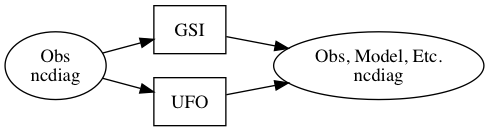



# Notes, 3/23/18

* Apparently, the IODA ncdiag reader/writer was created from an older copy of the GSI ncdiag reader/writer
    * Hopefully, this means that merging the two reader/writers will be easier

## UFO's usage of the IODA ncdiag reader/writer

* Reader and writer are used

* Different obs types use different modules in IODA

* The newer style appears to be the one where m_diag_obstype.F90 is used
    * This is stripped down from read_diag.f90

* read_diag.f90
    * has capability to read the old binary diag format and the new netcdf diag format

* Objects in UFO are created from BasicObsData class and extended with ncdiag fortran structures
    * The ncdiag reader is called to fill in the ncdiag structures

### ufo/src/ufo/radDiag_mod.F90

* Uses read_diag.f90 module from IODA source
    * read_radiag_header(ftin,npred_radiag,retrieval,header_fix,header_chan,data_name,iflag,lverbose)
    * read_radiag_data(ftin,header_fix,retrieval,data_fix,data_chan,data_extra,iflag )

* Calls
    * set_netcdf_read(.true.)
    * read_radiag_header(luin,npred,retrieval,self%header_fix,self%header_chan,self%header_name,ier,lverbose)
    * read_all_radiag(luin, self%header_fix, retrieval, self%datafix, self%datachan, self%dataextra, nobs, ier)

### ufo/src/ufo/roabDiag_mod.F90

* Uses m_diag_raob.f90 module from IODA source
    * write_split_raob_diag_nc(infn,raob_header, raob_mass, raob_wind, append_suffix)
    * read_raob_diag_nc_header(infn,raob_header)
    * read_raob_diag_nc_mass(infn, raob_header, raob_mass, ierr)

* Calls
    * read_raob_diag_nc_header(filein,self%header)
    * read_raob_diag_nc_mass(filein,self%header,self%mass,ier)

### ufo/src/ufo/aircftDiag_mod.F90

* Uses m_diag_aircrf.f90 module from IODA source
    * write_split_aircft_diag_nc(infn,aircft_header, aircft_mass, aircft_wind, append_suffix)
    * read_aircft_diag_nc_header(infn,aircft_header)
    * read_aircft_diag_nc_mass(infn, aircft_header, aircft_mass, wbgn, wend, ierr)

* Calls
    * read_aircft_diag_nc_header(filein,self%header)
    * read_aircft_diag_nc_mass(filein,self%header,self%mass,wbgn,wend,ier)
    

### ufo/src/ufo/ufo_geovals_mod.F90

* Uses nc_diag_read_mod.f90 from IODA source

* Calls
    * nc_diag_read_init(filename, iunit)
    * nc_diag_read_get_dim(iunit,'nobs')
    * nc_diag_read_check_var(iunit, vars%fldnames(ivar))
    * nc_diag_read_get_var_dims(iunit, vars%fldnames(ivar), nvardim, vardims)
    * nc_diag_read_get_var_type(iunit, vars%fldnames(ivar))
    * nc_diag_read_get_var(iunit, vars%fldnames(ivar), fieldr1d)
    * nc_diag_read_close(filename)

### ufo/src/ufo/ufo_obs_seaicefrac_mod.F90

* Uses nc_diag_read_mod.f90 from IODA source

* Calls
    * nc_diag_read_init(filename, iunit)
    * nc_diag_read_get_dim(iunit,'Rows')  
      ...
    * nc_diag_read_get_var(iunit, "Latitude", field)  
      ...
    * nc_diag_read_close(filename)


# Meeting with Clara, 3/29/18

* AMSU-A is a subset of "tovs"

* GPSRO and AMSU-A are raw BUFR formats

## Timestamps in the ncdiag file

* All of the raw BUFR formats need to calculate a reference time and a time offset
    * For window selection downstream
    * Data shows up every 0, 6, 12 and 18Z
        * These times (0, 6, 12, 18Z) are called analysis times
    * raw BUFR gives YEAR, MNTH, DAYS, HOUR, MINU, SECO
        * Take these values and calculate offset from the reference time
    * Reference time is calculated:
        * Find earliest time from all selected messages (msg_date values)
        * From the earliest time, move forward to the next analysis time (0, 6, 12, 18Z)
            * This analysis time becomes the reference time
    * Store the reference time in an attribute
        * Same reference time for all subsets
    * Store offset time in variable

* prepBUFR already does the reference/offset time scheme
    * Make prepBUFR output match that of raw BUFR
        * Reference time goes into the same named attribute
        * Offset time goes into the same named variable

* Store reference time in hours
    * Time values end with hours which is one of: 0, 6, 12, 18Z

* Store offset time in seconds

* Jeff's gpsbufr2nc.py is almost what we want
    * The reference time is stored as the units on the variable "Time"
        * Units: "seconds since YYYYMMDD HH:00 UTS"
            * The reference time is stored in the YYYYMMDD HH:00 part
    * The offset time is stored as the values of the variable "Time"
    
    * Don't use the netcdf variable names from gpsbufr2nc.py
        * Use the older (mnemonic) names

* Once completed, we should be able to get rid of storing msg_date


# Meeting with Yannick, 3/29/18

* Now have 5 obs types
    * Aircraft
    * AOD
    * Radiance (AMSU-A)
    * Radiosonde
    * GPSRO

* Moving forward
    * Don't add anymore obs types
    * Get the code streamlined with these 5 obs types
        * Converge ncdiag reader/writers
        * Make it easy, efficient to add an obs type
            * Currently, to add an obs type, the developer will cut-and-paste code for an existing one
                * Creates lots of duplicated code
                * We have diverged into two methods
                    * read_diag.f90, read_aod_diag.f90 --> radiance and AOD obs types
                    * m_diag_aircft.f90, m_diag_raob.f90 --> aircraft and radiosonde obs types
                    * Not sure where GPSRO will land (could be a third type)
            * Put obs types into classes (OO approach)
                * Eliminate redundant code
                * Much easier to maintain
       * Once adding an obs type is efficient, document how this is done


# Notes, 4/3/18

## Steps to move ioda repo from UCAR to JCSDA

* Make clone from UCAR/ioda
* Change remote to JCSDA/ioda
* Push
* Go through all bundle repos and change CMakeLists.txt to reference JCSDA/ioda

* Coordinate with developers
    * Check who owns feature branches in ioda
    * Send emails to everyone asking to push their work and wait for the move
    * Send email when move is completed asking to switch to JCSDA/ioda

## Steps for completing Xin's pull request and moving ioda repo

* Xin: Merge develop into feature/aircraft
* Xin: Issue pull request for ioda and ufo repos
* Steve,Yannick: Review, merge pull requests
* Steve: move ioda repo from UCAR to JCSDA

## Xin's task to add multiple obs for Aircraft

* Xin is held up due to limitation in ioda ncdiag files and reader
* Need to merge GSI and UFO ncdiag readers
* Should use a standard naming convention for ncdiag
    * Gives access to 3rd party software (plotters perhaps?)
    * CF is a candidate
        * Climate/Forecast metadata standard: http://cfconventions.org/index.html  
* For expediency, Clara is using the BUFR mnemonics for the ncdiag naming convention
    * Convert to standard convention after flow is enabled
* Xin has another task he can work on while the ioda ncdiag reader/writer is fixed

## Steps to fix ioda ncdiag reader/writer and enable multiple Aircraft obs

* Adopt BUFR naming convention for now
* Fix IODA readers to use BUFR naming convention
    * At this point multiple obs for Aircraft should be working
* Merge UFO/GSI ncdiag readers/writers
* Create interface that encapsulates what's stored in the file
* Change file to standard naming convention later

## Discussion with Xin

* May need to provide both netcdf and odb as file storage options
    * Some collaborators (universities) may be reluctant to use ODB because it takes up a lot of space
        * How much space does ODB consume?
    * If this is a problem, providing netcdf as an option could be a way to address this
        * This would speak to the objective of making JEDI easy to use

# CF conventions

* CF is a metadata spec that can be used in netcdf  
    http://cfconventions.org/index.html  
    * Articles  
        https://www.earthcube.org/group/advancing-netcdf-cf  
        https://earthdata.nasa.gov/user-resources/standards-and-references/climate-and-forecast-cf-metadata-conventions  
        http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-20010629.htm

* CFA is for aggregated fields in CF format  
    http://www.met.reading.ac.uk/~david/cfa/0.4/

* Python interface
    * cf-python  
        https://cfpython.bitbucket.io/  
        * Looks mature
        * Great documenation  
            https://cfpython.bitbucket.io/docs/latest/a_first_example.html  
        * cf-plot
            * Can plot netCDF CF fields
    * pynetCF  
        https://github.com/TUW-GEO/pynetCF  
        * Does not look as mature as cf-python

* C/Fortran interface
    * UCAR has a library for netCDF CF  
        https://www.unidata.ucar.edu/software/nccflib/  
        * C and Fortran
        * Looks like it was abandoned a number of years ago
    

# NOAA Space Weather meeting with DTC MET, 4/12/18

* Tara Jensen (NCAR)
* MET -> Model Evaluation Tools
* Research Applications Lab - NCAR
* Weather forecast verification, tools and resources

## R verification libraries

* Based on R statistics language
* Guts of statistical ops in MET

## MET (Model Evaluation Tools)

* Free
* Modular forecast evaluation
* Gridded Obs, Point Obs
* Originally developed to replicate EMC mesoscale evaluation system
* 15 interpolation methods
* Flexible
    * Compare Obs and Model
    * Compare two Models
    * Handles ensemble datasets
* Can identify "objects" and compare them in different datasets
    * T-storm, MCS, etc.
    * Spatial displacement
    * Temporal displacement
* Provide Python wrappers to help with flows
    * MET+
    * github: NCAR/metplus
* Core is C++ and some Fortran
* Integrating FV3

* Mark: complementary with JEDI
    * JEDI --> DA
    * MET --> Evaluate how well system is working

* What are the file formats that MET uses?

# Notes, 2/20/18

## Obs types test files

* Radiance
    * 2 files: Obs, GeoVaLs

* Radiosonde
    * 1 file: Obs + GeoVaLs

* Aircraft
    * 1 file: Obs
    
* We want all obs types to have
    * 2 files: Obs, GeoVaLs

* We want these for April 15, 2018, 00Z

* Clara pointed out that the Obs file from bufr2nc and Obs file from GSI are different
    * The GSI Obs file has been processed
        * Thinned, for example
    * These two files need to be distinguishable so that the reader can know if the processing has occurred
        * Clara started by using different variable names between the two Obs files
            * BUFR names for the bufr2nc output
            * Ncdiag-like names for the GSI output
        * It would be okay, not to much effort, to make the variable names consistent in these two files
            * Could use an attribute to mark differences, have the readers check this attribute
                * If the caller asks for bufr2nc obs and the atrribute say GSI, then issue an error

* The GeoVaLs and Obs files need to be traceable
    * Need to preserve connection between the Obs and corresponding GeoVaLs
    * Using indexes to do this
    * The Obs comes in indexed by observation number so this index is attached to the GeoVaLs profile


# Notes, 5/11/18

## ecbuild for standalone repos

* IODA depends on OOPS, so you need to point ecbuild to where OOPS has been built.
    * Say oops is built in ~/projects/oops/build
    * Then the ecbuild command for IODA looks like:

~~~~~~~~
# ioda repo is in ~/projects/ioda
cd ~/projects/ioda
mkdir build
cd build
ecbuild -DOOPS_PATH=$HOME/project/oops/build -Doops_BINARY_DIR=$HOME/projects/oops/build ..
~~~~~~~~

* The oops_BINARY_DIR definition is needed when the oops build is actually the oops part of the ufo-bundle build
    * In this case, the cmake config structure will try to load a ufo cmake config file
        * This only happens if oops_BINARY_DIR is not set
        * This loads ioda from the ufo-bundle build which breaks the ecbuild you are running
            * ioda from ufo-bundle build gets loaded, then your ioda project conflicts with that and ecbuild throws an error


## Classes

* ObsSpace is analogous to a mathematical space
* ObsVector is a vector in ObsSpace
* Locations are metadata for observations

# ObsSpace and ODB meeting, 5/15/18

* David
    * Not ready to be merged yet, will wait for UFO->IODA move
    * Has example of IODA using an ODB file
        * Read in data, pass on to UFO
        * Data is copied into the existing IODA data structures
    * Can't read in existing obs netcdf
        * Would have to add code to do this

* Yannick
    * Two netcdf files for UFO
        * Obs
        * Geovals
    * Don't want to spend time developing a netcdf to ODB converter
    * Obs netcdf
        * NCEP
        * From the "tank"
            * Converted from BUFR
    * Longer term
        * Use ObsSpace methods
            * getdb()
            * putdb()
            * Create tests for these methods
        * Currently, UFO accesses the IODA data structure directly

* ODB View
    * Peter Lynn (ODB expert)
    * HPC compatible (MPI)

* David
    * ODB API -> odbql
        * ODB query interface
        * Not implemented for HPC, MPI
        * Has some multiprocess capability
            * OpenMP (multi-thread)
            * Not suitable for many cores (100's or 1000's)

* ODB2
    * Open source
    * File format only
    * No parallel file access
    * Can do slicing of datasets (like HDF5 hyperslab)

* ODB1
    * API + file format
    * MPI compatible
    * Not open source
        * Yannick is trying to get this changed

* Table view of database
    * Oversimplification, but helpful for discussions
        * database is dynamic
            * columns change
            * every column may not have all rows filled
            * more dimensions (than 2D)
            * more than just a simple 2D table
    * Example of table view: Rows are obs number, columns are variables
        * ObsSpace getdb(), putdb() access columns of table
            * Transfer data to in-memory ObsVector
* Yannick
    * Want to write out files so we can re-run jobs quickly
    * May want obs to be split into "monitor" and "active" bins
        * Monitor obs are for checking processes
        * Active obs are the ones actually being used in the assimilation

## Next Steps

* Complete move of ObsSpace from UFO to IODA
    * Adjust David's ODB interface
* Steve send BUFR files to David
* Write a Locations test
* After H(x) calculation, write out results
* Get access to ODB repo (ECMWF)
    * Or fork into JCSDA
* Update eckit

## Issues

* David: Portability issue with ctypes in Fortran
    * c_int, c_long are not portable
        * These mean different things on 32-bit and 64-bit machines
    * Looks like there is a c_int32_t that fixes the size regardless of machine width
        * Is this what David is suggesting?

## ECMWF ODB

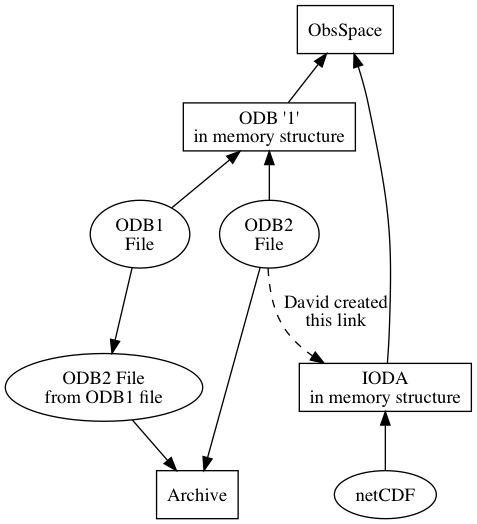


* ECMWF is working on merging ODB1 and ODB2 file formats
    * ODB2 was originally designed for reanalysis
        * Facilitates data exchange
            * Can do SQL-like queries on ODB2 files in the archive
            * ODB2 comes with Fortran, C++, Python API's to access the file
        * Operational use which requires parallel (fast) access, was not considered as much
    * Adding parallel access to ODB2
    * ODB has a netcdf reader, but it doesn't understand our obs netcdf layout

* Steps
    * License, open source for ODB1
    * What to do about ODB2, netcdf, hdf5 formats
        * Would like to only have to support one format
        * Lots of attachment to netcdf and hdf5 in community
            * Including opposition between netcdf and hdf5 camps


# Meeting with David Simonin, 7/3/18

* During visit to UKMO

* David works in Reading, UK

* David works on Radar systems

## Discussion of Radar Obs

* Any shape in 3D volume, plus time
    * Radiosonde -> 3D space, changes with time
    * Radar -> scanning surfaces

* Assoicate volume and time

* Difference of 2 radar obs (volumes)

* Can use lat, lon, time to represent a profile
    * But then need drift and time offsets for each measurement

* Radar beam
    * Associate what the measurement covers in (x,y,z,t)
    * Weighting of beam strength is different depending on distance beam has traveled
    * Conical beam shape
        * Beam width
        * Beam angle
        * Beam distance
        
        * Above three are enough to infer the extent of the atmospheric volume covered by the beam
            * For the forward operator
            
    * Succession of beams creates a scanning pattern
    
    * One beam has many obs associated with it
        * Distances from what the beam hits and reflects
    
    * Buoys on ocean have a similar view

* Issues come with model grid
    * At start beam is narrow and its width is a fraction of a model grid
    * As the beam travels, it expands and eventually covers more grids

* Need to store enough parameters about beam so that the model side can infer the volume that is covered

* Radar scan needs to remain intact
    * Can't split across multiple processors
    * Scan needs to be intact to reproduce error correlation

* Obs which are correlated need to be placed on the same process element (PE)
    * Need a way to keep track of obs correlation
    * In one scan, the obs are correlated
    * In the past, the processing of satellite obs have been ignoring this
    * New work is under way to take into account how obs are correlated to each other
    
* Organize obs by technology instead of obs type
    * Active sensors are alike -> use this as a subclass


# Meeting with Jeff W, 8/16/18

## Obs distribution

* Looking at Ensemble Kalman Filtering
    * Essence of technique is to only consider obs within a certain distance of model grid point
    * Reduces the size of y, R, ...

* When have multi-processes, want to retrieve obs in region ("halo") around model subdomain

* What is a good way to do this in a generic sense for IODA?
    * Will IODA ever need to know model information (such as grid locations)?

* Perhaps have OOPS get the halo from the State object and pass that onto IODA as a generic "within this region" filter
    * Is the model domain decomposed before calling ObsSpace constructor?

# Notes, 8/24/18

## Schematic of obsdb interface

* Appear as a 2D table
    * Rows are the type of data
        * ObsValue
        * ObsError
        * ObsQc
        * OminusA
        * OminusB
        * etc
   * Columns are variables
       * U, V, T, Q
       * Channel_1, Channel_2, ...
* If you ask for "ObsValue", you get the entire row
    * All variables, chained together in a vector
    * This would be the y vector in the cost function
* If you ask for "ObsValue" with a particular column, you get just those variables
    * col = 'T' would return just temperature in a vector
    * col = 'T, Q' would return temperature and moisture in a vector
    * col = '\*' would return all variables

* The underlying file and memory structures can be whatever we want
    * Do not necessarily have to mimic the way the interface looks
    * Just have to provide an interface that matches the above description

## Memory implementation of obsdb

* Three tables
    * ObsData
        * The entire table holds the y vector values
        * 3D array initially
        * Rows are "ObsValue", "ObsErr", "ObsQc", etc.
        * Columns are Variables
        * Pages are matched up with locations
    * ObsLocations
        * 2D array initially
        * Rows are locations
        * Columns are the items necessary for location specification
            * Latitude
            * Longitude
            * Time
            * Level (only for point data, such as Radiosonde)
                * Can be any of a number of vertical coordinate schemes
                * Radiosonde --> Pressure
    * MetaData
        * 2D table initially
        * Descriptive data such as Station ID, Aircraft Flight Number, etc.
        * Rows are matched up with records
            * Records are atomic units that are used for parallel processing distribution
            * Eg, individual soundings for Radiosonde, One set of channels for Radiance
    * Storage is optimized for Radiance since this will be vast majority of total obs data
        * The above scheme will be full for Radiance
        * The above scheme will be sparse for Radiosonde
    * Numbers that are used for bookkeeping
        * nrecs - total number of unique records
        * nlocs - total number of unique locations
        * nobs  - total number of unique observations
        * ncols - total number of variables
        * nrows - total number of rows in the ObsData array

    * Issues with this scheme
        * Sparse data will be stored as missing values in array
           * Need to strip out missing values as vectors are formed
           * Need to deal with proper locations of sparse data when doing 'putdb'
        * Eventually want something different than array to aviod allocating storage for sparse data

    * Missing values
        * Yannick has a version of ObsVector that process missing values
            * He'll do a pull request
        * Define a single missing value that is used everywhere

    * Methods
        * getdb
            * Walk through vars in order, stuff into output ObsVector

## Memory implementation for ObsVector

* Three arrays
    * Values
        * 1D array (vector)

    * VarIndex
        * 2D array
        * Rows are Variables
        * Columns (2) are index values for the Values vector
            * Col 1 is start of variable
            * Col 2 is end of variable

    * VarNames
        * 1D array
        * Rows are Variables
        * Entry is string

* Methods
  * Iterator
      * Returns value and variable name
      * Or provides getName() and getValue() methods

## Fullobs issues

* ioda_obsdb_mod.F90
    * ioda_obsdb_putvar and ioda_obsdb_getvar should be made private

* Eliminate obs vector handling of missing values
    * Missing values okay in obsdb, but not in ObsVector
    
* Looks like var list for assimilation is specified in the real DA runs in the model's config file
    * "variables" section

## ODB status

* ODB1 is not likely to become open source

* ODB2 is already open source
    * ODB2 is just the file format (no memory implementation)
    * Should have readers and writers

* We will likely adopt ODB2 for our file format


# Notes 9/4/18

## GNSSRO

* Get understanding of what needs to change to accommodate the new 2D obs operator for GNSSRO
* Geovals, Locations, Etc.
* ObsSpace

## ODB

* Wait on ODB installed in container
    * End of september should know what's okay to publish


# Notes 9/10/18

* Filtering cases
    * Use only channel 6 of AMSU-A data
    * Use radiosonde data only between these levels
    * Hpyerspectral Sounders (IR)
        * Thousands of channels
        * Only 100's being saved (transmitted) for now

* Assimilation windows
    * Tend to be 6 hours, following analysis cycles (eg, +/- 3 hrs)
    * Should locations time variable be the offset from cycle time?
        * Yannick specified absolute time
    * Condiser 1 hour updates for RAP/HRRR -> much narrower assimilation window

* Encourage people to use ODB so we can assess if it iwll be sufficient for our needs

* GNSSRO (Hailing)
    * Error calculation
        * Going through OOPS C++ to get the error
        * Variable name is specified in YAML in fv3-jedi
        * Not going through UFO
            * Obs Operator is not using this value
        * Only place this can be done (for now) is in IODA because it's coming though the C++ interface (read->getdb->etc.)
    * Need capability to select different obs error algorithms
        * This is acoommodated by teh YAML config where the user can specify an "obserror" value
    * Is it expected to have the pre-calculated obs error values in the obs file, or is it expected that IODA doe these calculations?


# Notes 9/11/18

* Yannicks whiteboard:

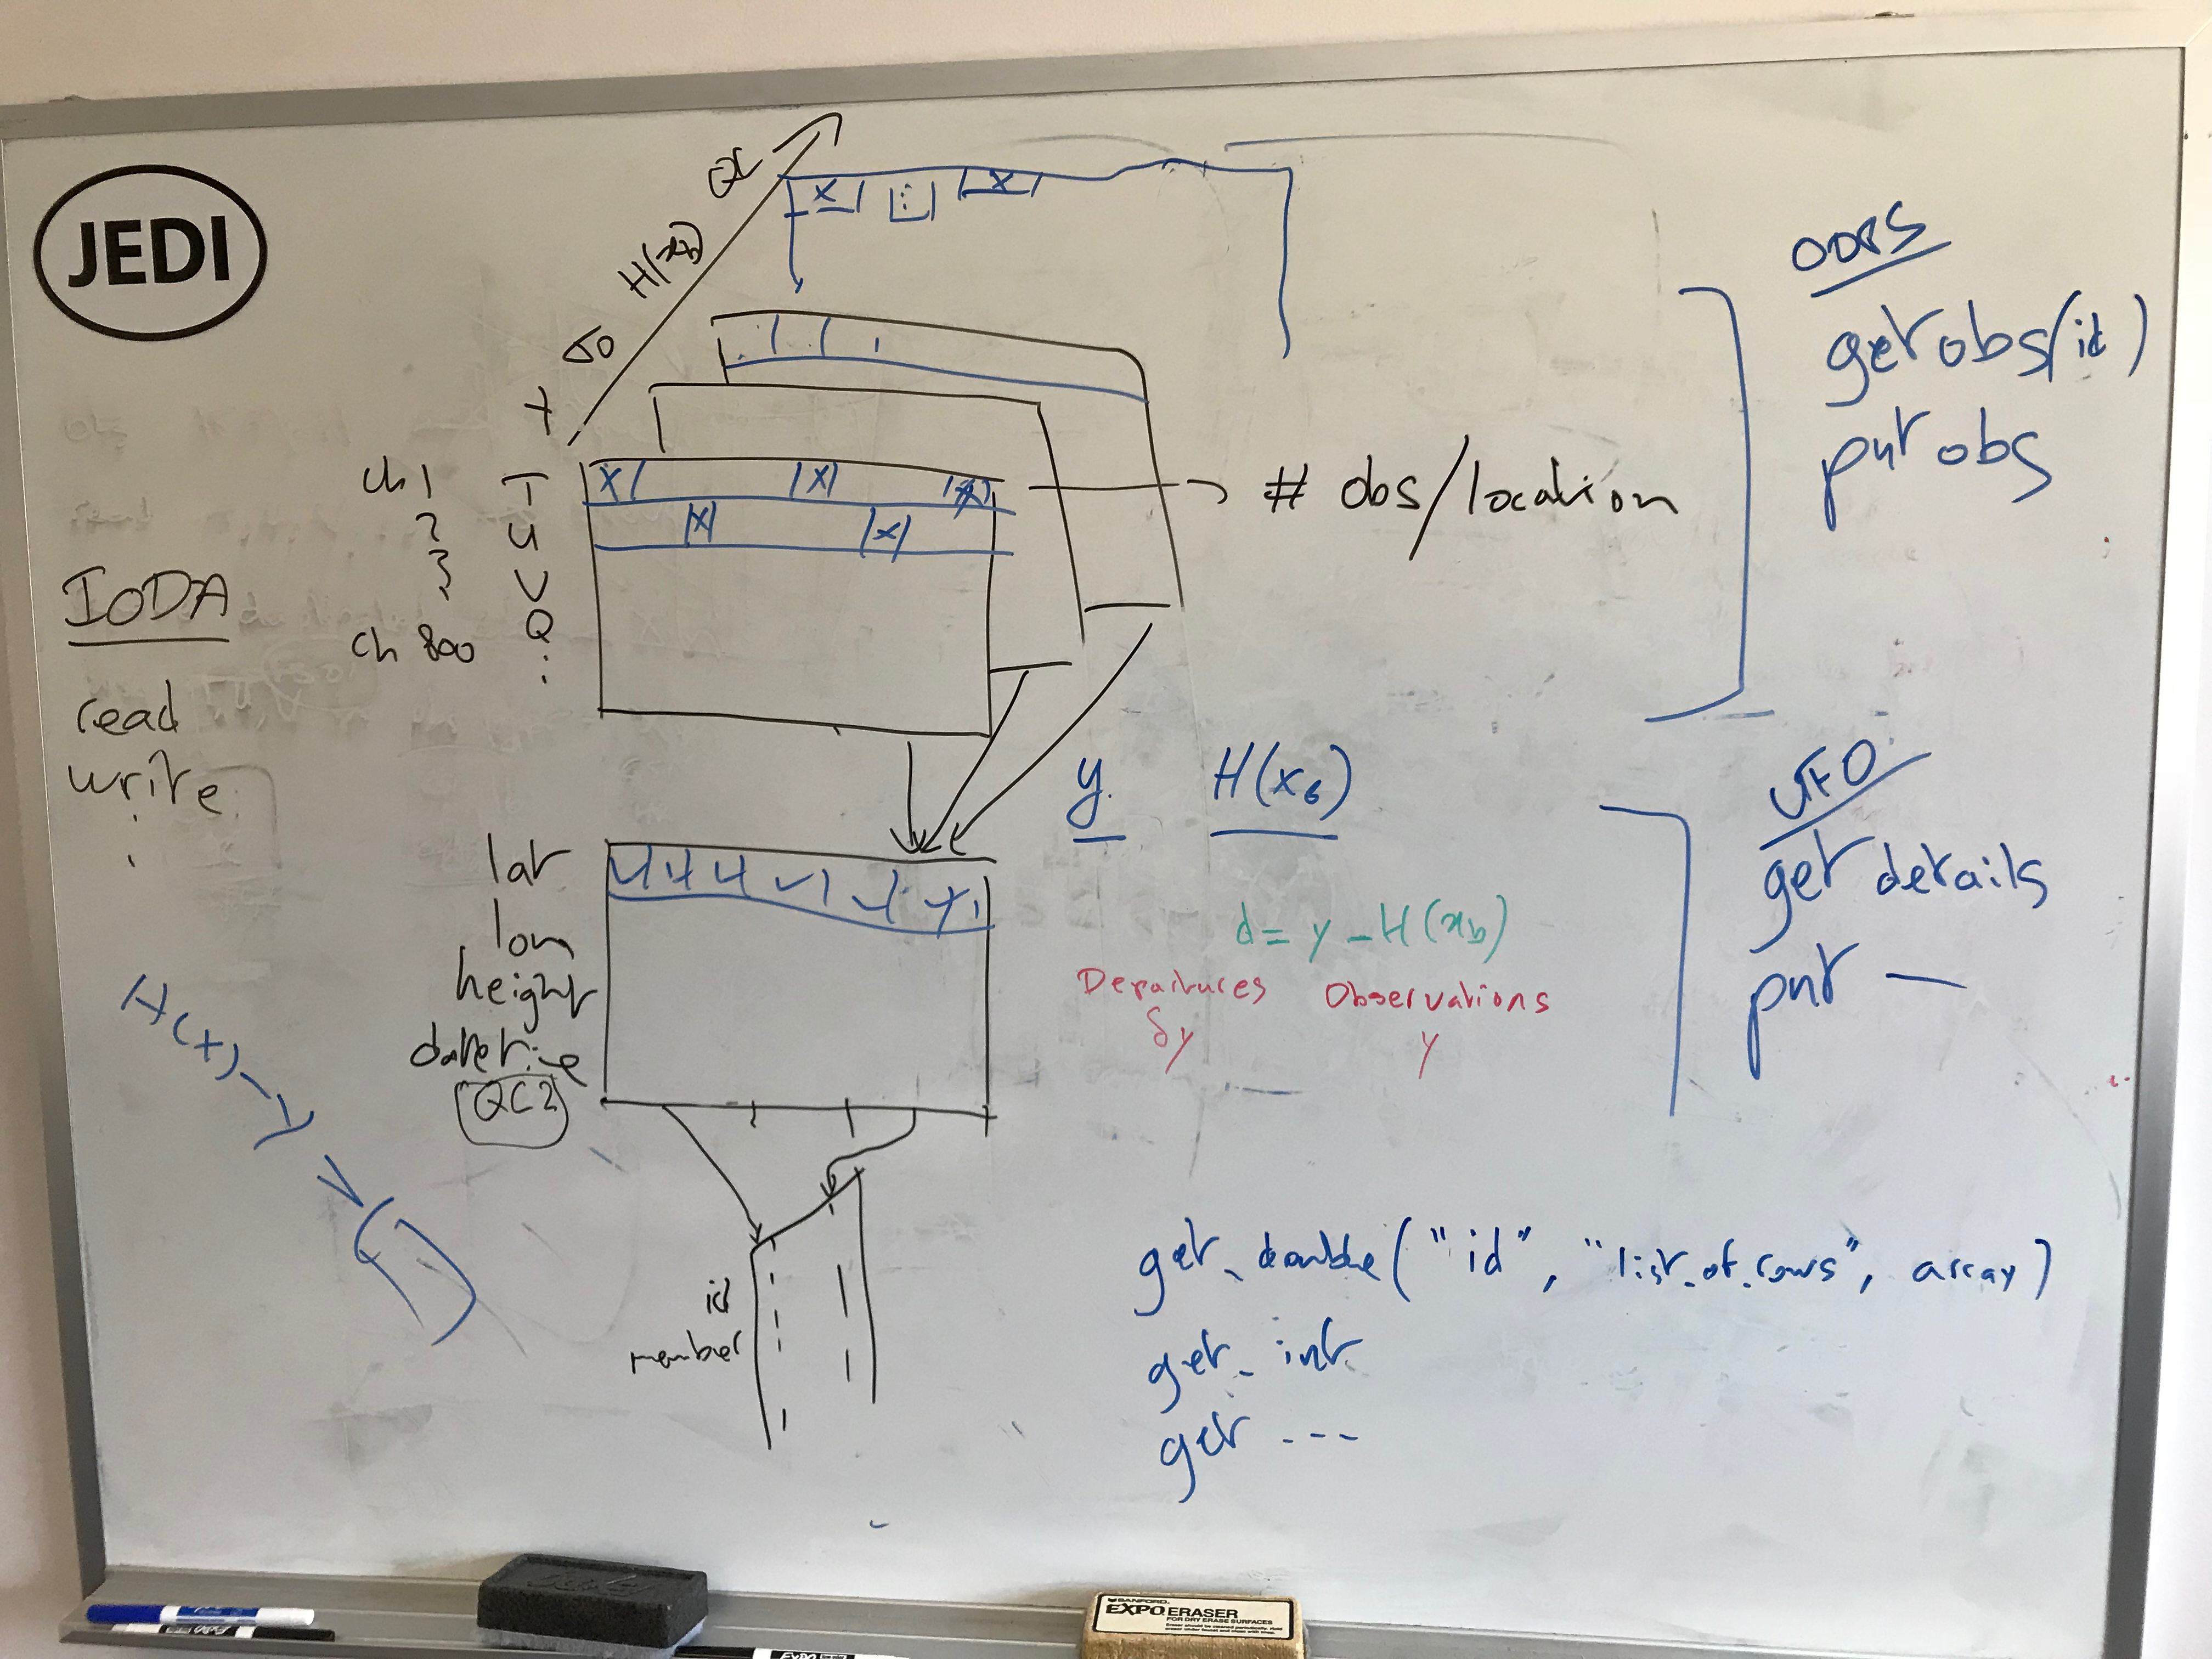

* Ensembles - one method to support is to have each member receive a mutually exclusive subset of obs
    * This would perhaps introduce a member id that works like record id
    
* Ablity to ingest more obs as system runs
    * Offload obs as you go too

* Missing value
    * Nan?
    * Problem with Nan is how to tell the difference between a fault that created a nan versus the mark for a missing value
    * Actually, this issue exists with any value you pick to represent "missing"
    * Solution is to keep map (another page in the obs data tables) that tracks the missing values

* With large data
    * Need fast I/O when running with thousands of cores
    * Find balance between one large file versus many small files

* File format and memory structure should be independent

* Want to have capability like SQL
    * get( ... where id = XXX ... )

* Filtering
    * Some QC must be done as system runs -> creates more missing values
    * May want to filter out obs as they are read in from file
        * This might be limited to when all variables at a given location are marked bad or missing

* Need to move Locations to UFO
    * Accommodate GPSRO, Satellite scans, etc
    * Where you need many locations for one obs (2D plane, eg)

* C++ implementation
    * Used at OOPS and UFO levels
    * Need to provide Fortran interface (to be used at the UFO level)

* C++ maps might be good for start
    * Like Python dictionary
    * Can have nested maps

* There are different classes for Departures and Observations
    * d = H(x) - y
    * d is Departures object
    * H(x) and y are Observations object
    * Observations has its own operatore such as '-'
        * This minus operator needs to be aware of QC/Missing map and insert missing values accordingly

# Meeting with NCAR, 9/13/18

* NCAR wants an ODB2 reader/writer
    * Use ODB2 data for DA runs

* ODB reader takes in UK Met Office versions of ODB2 files
    * Can't use GSI since GSI doesn't read ODB2
    * But we should be able to get geovals from the Met Office

* ODB2 files
    * Typically put all obs types into one file
    * Which way do we want to store files
        * One file with all obs types versus Multiple files - one per obs type

* Base class for ObsFile
    * Subclasses: NetcdfFile, OdbFile

# JEDI Core, 9/18/18

## IODA

### MultiIndex

* ObsData
    * Want contiguous memory -> 2D array -> nlocs X nvars
    * Access is whole set (2D)

* MetaData
    * Want row by row access -> 1D array -> nlocs
    * Access is row by row

* Change YAML
    * obsvalue: (not to be confused with id for getobs(), putobs()
        * var1
        * var2
        * ...
    * change name to "variables"?
    * need to have syntax for channels
        * 1-200, 305, 780-785

### Diagnostics

* Plotting tools may use the same in-memory data structure
    * wouldn't matter which file format we use

# IODA C++, 9/24/18

## Goals

* C++ data structure for obs data in-memory
* All obs types
* Doxygen documented
* Unit tests
* Done in time for November Jedi Academy (Nov 12-16)

## Constraints

* OOPS -> C++ interface
* UFO -> C++ and Fortran interface
* IODA -> C++ netcdf and odb2 interfaces
* Move Locations class to UFO
* GeoVaLs and obs data need to stay in sync

## Work

1. MultiIndex memory data structure
    * Xin
1. Netcdf interface
    * Steve H
1. ODB2 interface
    * Steve V.
1. Move Locations class to UFO
    * Anna
1. Handle missing values
    * Anna, Dan
    * GNSSRO hofx will create missing values
    * Linear algebra operations
    * ObsVector methods
        * Are there other places?
1. ObsVector updates:
    * ?
    * 2D storage
    * 2D view
    * 1D view
1. Convert/Port all obs types to new memory scheme
    * Multiple teams
    * Radiance
    * Radiosonde
    * Aircraft
    * AOD
    * Marine
1. Netcdf files
    * Steve H
    * 2D array for ObsData tables
    * Large data sets from GSI
1. Documentation of IODA interfaces
    * Steve H

## Roadmap

1. Get the radiosonde obs type working
2. Port all other obs types

# JEDI class structures for observation data, 11/28/18

* Context that IODA lives in

* There are two class structures:
    * observation space
    * observation vector

## observation space

* OOPS has three classes
    * ObsSpaces (note plural)
    * ObsSpaceBase
    * ObservationSpace

* The ObsSpaces object holds a vector of ObservationSpace objects, where each ObservationSpace object is associated with one obs type.

* The ObservationSpace object provides a templated interface to a specific ObsSpace object
    * It just passes methods through to the underlying ObsSpace object
    * The template allows for any system to provide the underlying ObsSpace object
        * Currently, the QG and Lorenz95 examples in OOPS provide their own ObsSpace classes
        * IODA provides the ObsSpace class that is associated with UFO and provides the access to many types of observation data

* The ObsSpaceBase provides an abstract base class for any ObsSpace class definition
    * Ensures the minimal set of methods and data members required to operate with OOPS

* IODA has one ObsSpace class
    * Currently, implmented in Fortran, but the top layer is in C++ which provides an interface to the Fortran implementaion
    * Soon to come is a full C++ implementation (no need for Fortran, and the Fortran implementation inserts unnecessary complexity)

## observation vector

* OOPS has one class
    * ObsVector
        * Templated interface (analogous to ObservationSpace) for a specific ObsVector object

* IODA has one class
    * ObsVector
        * Fully implemented in C++

## diagram

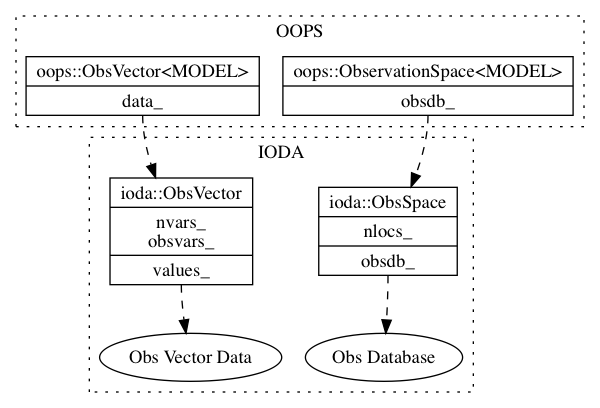

# Performance test debug notes, 1/7/19

* file read time
    * Sequence is:
        * file open
        * read 14 variables
        * file close
    * Sequence gets repeated 10 times
    * Timing for just one sequence
        * netcdf:   0.09 s
        * odb api: 16.99 s
    * obd api prints out lots of status line
        * emulated this with netcdf print statments
        * this changed 0.09 to 0.10 s (minimal additional time)
    * odb api code does a single fetchone call for each variable
        * change to fetchall (all 14 variables in one call)
        * slows down to 20.91 s!
    * odb api code is issuing one sql call per variable
        * change to grab all 14 varialbes in one sql call
        * speeds up to 7.04 s
        * large impact, but still much slower than netcdf

* seg fault in odb api
    * occurs when you try to remove the file open and close from the sequence
        * open file, run the test with repeated sequences of reading 14 variables, then close file
        * netcdf is okay with this flow
    * odb seg fault goes away when reading 1 variable and repeating sequence 3 times
    * odb seg falut goes away when reading 2 variables and doing the sequence once
    * not clear what issue is, but seems to be mitigated when greatly reducing the repitition
        * memory leak?

# Ioda converters notes, 1/9/19

## YAML config

* General: specify what tuples comprise the keys

* Specific:
    * ODB converter config
    * GSI converter config
    * etc.

* General top-level interface
    * arguments: (ObsFile, Input YAML, OutputFile, OutputYAML)
    * Input YAML describes mpapping from input names to output names
    * Output YAML describes what goes into the output file

* Input YAML
    * Map input var names to output var names
    * Vars that comprise date, time
    * Etc.

* Output YAML
    * Three tables
        * Record variables
        * Location variables
        * Obs variables

| Record Vars | Key? (Y/N) |
|:------------|:----------:|
| station_id  | Y          |
| station_elevation | N    |
| launch_date_time  | Y    |


| Location Vars | Key? (Y/N) |
|:--------------|:----------:|
| latitude      | Y          |
| longitude     | Y          |
| date_time     | Y          |
| scan_angle    | N          |
| scan_position | N          |


| Observation Vars | Metadata? (Y/N) |
|:-----------------|:---------------:|
| brightness_temperature | N         |
| temperature            | N         |
| pressure               | N         |

* The Metadata column may not be necessary
    * Could be used to place one variable into both obs value and metadata


# MongoDB phone call, 1/22/19

## People
* Rohan Oswal - sales manager
* Gary Taylor - sales tech

## Notes

* Essence of our application
    * Diparate systems --> Same View --> Common Data Model

* MongoDB is a JSON based data store

* MongoDB has Python, C++ (and other) APIs
    * Requests for data create an object in memory

* AWS
    * Mongo has parnership with Amazon
    * Can purchase licenses through Marketplace

## MongoDB
* MongoDb Community
    * Open source
    * Low support
* MongoDb Enterprise, Advanced
    * Licensed
    * LDAP, authorization system
    * Encryption
    * 24x7 support
    * On demand training
    * Operational tooling
        * OpsManager
        * Maintanance
        * Deployment
* Good for our "fast" mode
* Probabaly should use another system for our "easy" mode (archive)
    * Data Lake model
    * Petabytes
    * Hadoop (MongoDb works well with this)
    * S3 Buckets on Amazon capability coming soon
        * Beta this summer
* Have data live in MongoDb for 60 days, then go into the archive
   
## MongoDB Prototype

* White papers, etc. for guidance
    * Send these to us

* MongDB professional services, consulting

* Deep dive workshop
    * On-site
        * Can do off-site, but prefer on-site
    * 2 to 4 hours
    * Requirements gathering, schedule, etc.

* Proof of value (concept) plan
    * Acceptance criteria
    * Prototyping

* Rohan will be in Denver
    * Available after President's Day (week of 18th)

* ATLAS
    * Sandbox
    * Part of cloud service
    * Paid sandbox has high security
    * Free sandbox has low (or none) security

* If we want to compare local MongoDB to local netcdf access
    * Need to install local Enterprise
    * This is free since all code is open source
        * Charges are for cloud service, support, etc.
    

## Next steps

* White papers to us
* Do we need to have FEDRAMP certification for secure data?
* We start on our own
    * MongoDB will help with light support
* Rohan visit us the week of Feb 18th
    * Figure out next steps



# Notes, 2/15/19

* IODA should perform minimal filtering
    * DA timing window
    * ObsSpaceView subsetting

* Neet to distinguish between bad data and missing data
    * Bad data example is instrument saturation

* ObsSpace holds a communicator object because different obs types may use different communicator groups

* ObsSpace holds the Distribution object because different obs types may use different distributions

* Be careful about using netcdf capabilities that odb can't handle
   * OR get the capability into ODB
   * Example
       * netcdf has ability to store structs
       * called compound data type

* netcdf does not have a native DateTime data type

* Error values from GSI are actually error variance

# NASA, Adaptive Thinning, 7/18/19

## NASA attendees

* Erica McGrath-Spangler
* Oreste Reale
* Manish Ganeshan
* Will McCarty
* Ron Gelaro

## JEDI core team attendees

* Anna
* Steve

## Thinning process

* Used for TC regrions
* Uses stats called "TC Vitals"
    * Location
    * Radius of storm
    * Intensity
    * Error estimates
    * Real time data (not the Best Track, which is post processed after the event)
* Takes the radius of storm as a guide to control degree of thinning
    * More thinning away from storm
    * Less thinning near storm

## Options for UFO

* Filters
* Already working on filter based on locality ("local obs")
   * Fits nicely with the NASA adaptive thinning process


## Plan

* Wait until local obs in UFO is implemented
    * Couple of months
* Contact each other and discuss how to proceed

# ODC, ObsSpace discussion, 9/13/19

* Performance test - Steve V
* ODC reader - Steve H
* ODC converters from BUFR - Steve H
* IODA memory container - Xin, Ryan

* Questions/notes
    * There is a link between memory layout and file layout in regard to performance
        * ODB2 and Netcdf are different enough that you would organize things differently in the reader to optimize performance
        * How do we get a fair comparison, given the above?
    * Fast data store (DA run) vs. Easy data store (archive)
        * Do these have to be the same file type, and file layout?
    * Can we reformat ODB2?
        * Do existing tools require existing layout?
    * Netcdf seems much more flexible
    * How do other systems work with Fast/Easy perspective?
        * IFS - what are they using for their Fast store?

# Ryan, 9/20/19

* Looking at container class
* Test out scenarios (hopefully next week)
    * Implementation options
    * Use the netcdf memory model
    * Toy models
* What we need is like the netcdf memory model
    * memory store/buffer
    * handling types
    * hyperslabbing
    * We are duplicating the above functionality
* Redis
    * C++ API?
    * In-memory structure
    * Free - BSD License

# Steve V, 9/20/19

* ioda-converter
    * ODCB2 to netcdf worked
    * original file, stripped AMSU-A file
        * converted both
        * provided identical files
* better to convert netcdf to ODB2 so the files match
    * ioda-converter does some filtering
* odyssey
    * needs help navigating through the interface
* netcdf to ODB2
    * Fortran converter in obd_api
        * test file for development of the ODC reader
    * ODC/Odyssey
        * Identical file, column major org., use this for performance testing
* Is there someone who has dealt with the issue of many data sources to manage
    * Could we leverage this work?
    * IODA workshop, MET validation team
* We have more file sources than data sources
    * Multiple data tanks with overlapping obs data
        * Eg: AMSU-A BUFR (one data source), ECMWF, NCEP (two file sources)
    * How many paths do we need?
    

# Notes, 9/20/19

## ObsSpace container implementations

* MongoDB
   * This requires creating a device on teh file system that looks like a disk, but uses RAM (tmpfs)
   * Not good for NOAA since they won't support a new service
* Memcached and Redis
   * These require a server to be running
       * Utilizes shared memory
           * Does this mean one server per node?
   * Maybe work with NOAA constraint, but would have to have MPI pools to run the servers durning the DA flow

# Benedickt, 10/17/19

* GIIRS (existing instrument most like IRS)
    * Wei Han
    * U of Wisc Madison
    * Hyperspectral
    * IR sounder
    * First geostationary IR sounder

* IRS
    * "InfraRed Sounder"
    * Hyperspectral - 1700 channels
    * Store principal components (PC) from EOF analysis
        * First 100 PCs
    * Working on channel selection algorithm
        * Determine which channels are best for assimilation
    * BUFR
    * Geostationary
    * Europe images every 15 minutes
    * Full disk every 1-2 hours

# Notes, 10/21/19

* Cloud storage interface
    * TSAR - format/interface, Jeff W.
    * ODB2 --> TSAR --> IODA Archive
* Ming's Fortran converter
    * Code organization
        * get_obs.F90
            * module_prep_bufr
            * module_obs_conv_pt
            * module_obsncio
            * module_time
    * Flow
        * Read namelist
        * loop over obs types
             * initial_prepbufr (obs_conv_pt, read_prepbufr constructors)
             * decode_prepbufr_all (read bufr, extracts data)
             * writept
             * writencfile
                 * initial
                 * write
                 * destroy
             * destroy_prepbufr
     * Test case
         * 25,323 locations
         * 42 sec run time!
* ODC
    * eccodes
        * Tarball: eccodes 2.13.1
        * For Python3: first install eccodes, then install python eccodes bindings

```
# build from tarball
cmake -DCMAKE_INSTALL_PREFIX=... -DENABLE_PYTHON=1 -DENABLE_FORTRAN=1 ..
make -j4
ctest
make install

# install python bindings, after build, test, install of above
python -m pip eccodes-python
```

# Performance check, 12/26/19

* AWS EC2 Instance
    * ioda testing-singularity
    * 3.226.35.84

* Experiment
    * A set is 5 runs of test_fv3jedi_hyb3dvar_gfs
    * One set with netcdf, the other set with odb
    * Obs files:
        * aircraft medium
        * sondes medium
        * gnssro small
        * amsua_n19 medium
    * ODB files
        * ~/projects/data/testinput_tier_1/*.odb
        * link these to: ~/projects/fv3-bundle/build/fv3-jedi/test/Data/obs
    * YAML files and runs
        * ~/projects/fv3-bundle/build/fv3-jedi/test/testinput/
        * cp hyb-3dvar_gfs.yaml to hyb-3dvar_gfs_nc.yaml
        * copy hyb-3dvar_gfs_nc.yaml to hyb-3dvar_gfs_odb.yaml and change nc4 to odb
        * link hyb-3dvar_gfs_nc.yaml to hyb-3dvar_gfs.yaml
            * run test 5 times saving LastTest.log file each time
        * link hyb-3dvar_gfs_odb.yaml to hyb-3dvar_gfs.yaml
            * run test 5 times saving LastTest.log file each time

* copy of results on MacBook
    * ~/projects/data/ODB/Trial3dvarRuns
    * Script to extract timing reports at end of log files
        * grab_stats
        * Collects all of these sections into one file
    * create tar file with results
    * TimingSummary
        * timing report from grab_stats

```
Netcdf runs:
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        62.81       98.68       87.05        0.73       41.20
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       187.26      278.68      218.79        1.83       41.78
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        66.70       97.84       85.90        0.72       36.25
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       129.13      202.81      177.32        1.49       41.55
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        66.78       98.85       87.95        0.74       36.47
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       131.19      203.77      178.08        1.50       40.76
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        62.34       98.12       86.92        0.73       41.17
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       131.47      204.56      177.87        1.49       41.09
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        61.50       99.03       86.91        0.74       43.18
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       123.17      202.10      173.77        1.48       45.42
Odb runs:
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        22.66       29.62       27.27        0.23       25.51
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       119.31      199.75      171.31        1.45       46.95
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        22.68       29.86       27.53        0.23       26.07
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       115.67      195.79      169.18        1.43       47.36
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        21.23       29.78       27.10        0.23       31.56
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       118.25      197.09      169.87        1.44       46.41
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        22.93       30.22       27.88        0.24       26.13
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       112.08      197.70      168.93        1.44       50.68
  OOPS_STATS ------------ Parallel Timing Statistics (   6 MPI tasks) ------------
  OOPS_STATS  Name                                               :    min. (ms)   max. (ms)   avg. (ms)     % total   imbalance (%)
  OOPS_STATS oops::ObsSpace::ObsSpace                            :        21.85       29.82       27.14        0.23       29.39
  OOPS_STATS oops::ObsSpace::~ObsSpace                           :       127.53      195.16      171.78        1.45       39.37

```

* Put results on S3
   * s3://data.jcsda.org/downloads
   * 3dvar.stats.tar.gz

# IODA test data on S3, 2/10/20

## Organization on S3

* AWS S3 console
* jedi-test-files bucket
    * Directory structure under jedi-test-files mimics branches in ioda repo
* If have a feature branch in a PR and need to update obs files
    * Download the tar file from jedi-test-files:ioda/develop
        * testinput_tier_1.tar.gz
        * Unpack, add/remove files
        * Repack
            * on Mac, when repacking, shut off the mechanism that creates the ``._*`` version of the files in the tarball
                * export COPYFILE_DISABLE=true
        * Create md5 file: testinput_tier_1.tar.gz.md5
            * md5 -r testintpu_tier_1.tar.gz > testinput_tier_1.tar.gz.md5
            * Edit testinput_tier_1.tar.gz.md5
                * Add one extra space between checksum and file name
                * The cmake test is using cmake built-in md5sum to validate the tar file, and md5sum will add the extra space
    * Go to ioda/feature directory under jedi-test-files
    * Create directory with same name as feature branch name
    * Upload new tar and md5 files

# Ryan's HH interface, 2/10/20

* ioda-scratch repo
* to build:
    * remove ~/.cmake/packages/Eigen3
        * This file is forcing find_package to look in jedi-stack build directory for includes, libs, etc.
    * cmake -DEigen3_DIR=/opt/modules/core/eigen/3.3.5/share/eigen3/cmake path_to_cmake_config
* Modeled on HDF5
    * HOFFSETOF macro
        * based on C offsetof macro
    * Used in compound data types
        * frames in IodaIO could be done this way
        * look at compound.cpp example
            * Not sure, the compound type is for a custom c structure
            * One struct could be a frame, but have to build it on the fly

# C++ r-value ref vs l-value ref, 2/10/20

* r-value
    * Does not have an assigned memory location (anonymous, "readonly value"?)
    * Can only be used on right side of assignment
    * Can't assign to r-value
* l-value
    * "locator value", has a memory location
    * Can be used on either side of assignment
* l-value reference
    * Single ampersand
    * Uses copy semantics since the memory that the reference points to must stay intact
* r-value reference
    * Double ampersand
    * Uses move semantics since the memory that the reference points to is understood to be temporary
    
* The r-value reference can be more efficient for constructors, assignment operator overloads, and function parameters since move semantics can be invoked
    * The std::move() function converts it's arguments to r-values which then forces move semantics to be invoked

# Difference between Eigen::Array and Eigen::Tensor

* Rank
    * Eigen::Array can only be either 1D or 2D
    * Eigen::Tensor can be much higher rank
* Suite of operators
    * Eigen::Array has large suite of operations
        * But many operators relevant to IODA are covered by both types
            * Element-wise math
            * Indexing
            * Maps (an array or tensor view over pre-allocted memory)
        * Operators only available for Arrays
            * Blocking

# Converters, 3/6/20

## GIIRS LW radiance

* Wei Han (U Wisc)
* feature/giirs-lw branch, PR

## AOD

* Sarah Lu

| Satellite | Instrument | Positioning | Obs file type |
|-----------|------------|-------------|---------------|
| NOAA-20 | VIIRS | polar orbiting | netcdf |
| GOES-16 | ABI| geostationary | netcdf |
| Terra, Aqua | MODIS | polar orbiting | bufr |

### File layout

#### GOES-16 ABI

| Variable | Quantity |
|----------|----------|
| AOD(y,x) | observation |
| DQF(y,x) | QC marks |
| t        | Time, single value, midpoint of image scan |

* x = 1500
* y = 2500

#### NOAA-20 VIIRS

| Variable | Quantity |
|----------|----------|
| AOD550(Row, Column) | observation |

Row = 768
Column = 3200

#### MODIS

* Message: NC008041 (MODIS AOD)
* Subset order:

| Variable | Quantity | Value |
|----------|----------|-------|
| SAID | satellite id | 748 |
| AODS | AOD source | 1 |
| CLONH | high accuracy longitude | degrees |
| CLATH | high accuracy latitude | degrees |
| YEAR | year | integer |
| MNTH | month | integer |
| DAYS | day | integer |
| HOUR | hour | integer |
| MINU | minute | integer |
| SECO | second | float |
| SOZA | solar zenith angle | float |
| SOLAZI | solar azimuth angle | float |
| SCATTA | scattering angle | float |
| OPTD | optical depth observation | float |
| AEROTP | aerosol type land | code |


### Plans
   * GOES-16 first, NOAA-20 second, MODIS third
   * Sarah look up what variables in files mean and what is needed by CRTM
   * Steve create small test files
       * ncks for netcdf
       * py-ncepbufr for bufr (?)
           * check if py-ncepbufr has writer

# Ryan notes, 3/9/20

* Rahul and Dan might be intereseted in ObsSpace refactoring
    * Passing grid info around JEDI using ATLAS
    * Currently this is too much data
    * Want to streamline what is passed around

* Ryan will discuss with Rahul on Tue (3/10/20)

* Ryan will create a sketch of what the interfaces will look like by Fri (3/13/20)
    * Wait until meeting with Rahul to see if worthwhile

# Steve V notes, 3/11/20

* How much work to have IodaIO read ECMWF/MetOffic ODB format
    * Two main issues:
    * Reorganizing data
        * Radiance data is 2D but stream comes in one column
            * Without a guaranteed format, cannot know dimensions until all data read in
        * Conventional data
            * can have missing data (locations not encountered for all variables)
            * sometimes get repeated locations for same variable
                * one is missing value, the other is non-missing
                * both are non-missing (rare, but does happen)
     * ECMWF and Met Office have similar formats, but encoding is slightly different
         * Eg., varno, verco, varno_vertco_variable scheme is used, but encoding is different
         * Email exchange between Steve V and David D
     * Look at ioda-converters for ODB to get an idea of the issues that need to dealt with
         * YAML
             * MO_* -> met office (different config for different report types)
             * ear5_* -> ECMWF

* Not a trivial problem
    * probably a couple weeks

# ioda-converters on mac, 5/4/20

* the /opt/modules netcdf libraries and miniconda3 netCDF installation are out of sync
     * /opt/modules netcdf 4.7.0
     * miniconda3 netcdf 4.8

* Need to allow python to grab netcdf libraries from the miniconda3 installation
    * Unset DYLD_LIBRARY_PATH
    * OR Unload netcdf, pnetcdf, hdf5 from modules

* Issue with FindNetCDF.cmake
    * Wants to run nf-config for Fortran component and ncxx4-config for CXX component, but miniconda3 installation only has nc-config
    * If you point cmake to the miniconda3 installation (netcdf_ROOT), then the cmake step fails because nf-config and ncxx4-config are missing

* Workaround
    * Use modules to do ecbuild
    * Then either
        * unset DYLD_LIBRARY_PATH
    * or
        * module unload netcdf, pnetcdf, hdf5

# Convert netcdf3 ioda file to netcdf4, 10/6/20

* `nccopy -d6 -u -4 nc3file nc4file`
    * -d6 -> compression (deflate)
    * -u -> change unlimited dims to fixed size
        * Without this, the unlimited size dims get their current size set to zero in the ioda-engines interface

# Add GPTL to ioda-engines, 10/6/20

* cmake/Dependencies
    * `find_package(jedicmake)`
    * `find_package(GPTL)`

* deps/HH/CMakeLists.txt
    * `target_link_libraries(HH PUBLIC GPTL::GPTL)`

* This set up is in the stash on my local clone in `projects/IODA_ENGINES/ufo-bundle`

# Performance testing, 10/6/20

* UFO test: test_ufo_opr_crtm_amsua
    * reads: amsua_n19_obs_1028041500_m_qc.nc4
        * 100 locations
        * 15 channels
        * 654 variables
    * h5dump and ncdump both run in about 0.5 seconds

* Test 1
    * ObsData constructor: 49.359 seconds!

* Test 2
    * Obs Data constructor: 49.071 sec
        * params deserialize: 2.0e-3
        * obsname_,obsvars_: 0.012
        * distribution: 1.71e-5
        * ObsFrame construction: 24.622
        * creatObsGroupFromObsFrame: 8.99e-4
        * initFromObsSource: 21.433

* Test 3
    * ObsData construction: 48.717
        * ObsFrame construction: 27.424
            * resetVarList: 2.252
            * resetDimVarList: 2.266
            * resetVarDimMap: 20.544
        * initFromObsSource: 21.276
            * dimsAttachedToVars: 20.660
            * createVariables: 0.133
            * tansfer data: 0.483

* Code change 1
    * resetVarDimMap and dimsAttachedToVars both call the same code underneath which forms a map going from variable name to list of attached dimensions (names)
    * Change was to call the underlying code once, and cache the map for down reference
    * After the code change the initFromObsSource process was reduced to 0.6 seconds

* Test 4
    * ObsData construction: 31.149 sec
        * ObsFrame construction: 30.354
            * listAllVars: 6.941
                * Called 3 times
                * once each in listVars, listDimVars, maxVarSize0
            * resetVarDimMap: 23.186

* Code change 2
    * listAllVars (takes about 2 sec, which is way too slow but tolerable) was being called from three different functions
    * Change was to call only once to set the variable lists being cached in ObsIo.
    * This removed 5-6 seconds from the ObsFrame construction.

* Test 4
    * ObsData construction: 27.284 s
        * ObsFrame construction: 26.680
            * genDimsAttachedToVars: 20.014
                * isDimensionScaleAttached: 19.832
                    * H5DSis_attached: 19.827   (1328 calls)

* Code change 3
    * nlocs is by far the most common first dimension variable on the file variables
    * alphabetization was making nlocs appear second in the dim var list
    * Code change was to force nlocs to be first in teh dim var list
        * The loop checking the dim vars does a break when the dim var is found, so this change minimizes the number of times H5DSis_attached is called

* Test 5
    * ObsData construction: 23.309 s
        * ObsFrame construction: 22.644
            * listAllVars: 2.258 (called once)
            * genDimsAttachedToVars: 20.263
                * isDimensionScaleAttached: 20.072
                    * HD5Sis_attached: 20.067 (683 calls)

* After code change 3, the number of calls to HD5Sis_attached did indeed get reduced, but the execution time didn't go down
    * Not sure why

# Exclude tests in UFO, 10/6/20

* Until performance issue is resolved, there are a number of UFO tests that time out
    * airs
    * cris
    * iasi
    * errf
    * nsstret

* These tests can be excluded from ctest:

```
cd ufo/test
ctest -E "airs|cris|iasi|errf|nsstret"
```

# DEBUG feature/ioda-engines-ioda-integration, 10/12/20

* UFO met office profile consistency check is failing

```
# run through ctest
ctest -VV -R test_ufo_profileconsistencychecks_wrongOPScomparison

# run raw commands
cd ufo/test
OOPS_TRAPFPE=1 ../../bin/test_ProfileConsistencyChecks.x testinput/profileconsistencychecks_wrongOPScomparison.yaml

# Data file is:
#  ufo/test/testingput/filters/met_office_profile_consistency_checks_bkgqc_repobs
```

* In the routine ProfileCheckTime::runCheck(), and arithmetic fault is occurring
    * The aritmetic fault is typically an underflow or overflow
    * The fault occurs in the loop on line 57
        * level_times[0] is a missing value -> continue
        * level_times[1] is 1.5304918e-41
        * level_times[2] is 1.54976436e-38
        * The fault occurs after index 0 on one of the extremely small (non-zero) values
    * The file has
        * level_times[0..31] = -3.368795e+38 (netcdf default fill value)

* Why do values in the file not get translated to internal missing values?

* file
    * \_NoFill = "true" -> use default fill values
    * \_NCProperties = "...." -> Netcdf format (ie, written through netcdf API)

* module list shows hdf5 version 1.12.0

* Turns out the issue was with a routine in `ufo/src/ufo/profile/EntireSampleDataHandler.`
    * `EntireSampleDataHandler::get()`
    * Loop on line 94, the variable allMissing gets set incorrectly
    * vec_all size is supposed to be 31, but gets set to 2922 (full size) by the ioda-engines interface
        * this causes the check in the loop to look at the whole vector instead of the first 31 entries
        * there are non-missing values past index 30 that cause the allMissing value to be set to false (when it should be true)
    * vec_all is getting read through the ObsData::get_db
    * The fix is to resize the data vector after the var.read() routine is executed
        * resize back to the original size of the data vector upon entry to the routine
        * This mimics the behaviour with the old ObsData container and get_db function

# Intel profiler, Vtune, 10/12/20

* Download console software onto Mac
    * Get the 2019 version since that matches what's on S4

* Run vtune hotspot analyzer on the command line on S4
    * `amplxe-cl -collect hotspots <command to be profiled>`
    * this creats a subdirectory in the current working directory: r0000.hs
        * "hs" suffix for hotspots
    * If you run multiple times, the output directory names get incremented
        * r0001.hs, r0002.hs, etc.

* Copy the subdirectory from S4 to the MacBook

* Run the Vtune GUI on the MacBook
    * Top-down tree
        * See % execution time along the call tree
    * Caller/Callee tree
    * Etc.

# Performance issue with ioda-engines integration, 2/8/21

* Two tests with greatest difference in runtimes between develop and PR
    * T1: test_ufo_linopr_vertinterp_satwind_metoffice
        * No grouping, MPI 4, write an output file
    * T2: test_ufo_function_satwind_indiv_errors
        * No grouping, no MPI, write an output file

* These tests use the following file
    * F: satwind_obs_1d_2020100106_noinv.nc4

* Runtimes for RelWithDebInfo

| Test | develop | PR | Notes |
|------|---------|----|-------|
| T1 | 0.0987 sec | 10.2 sec | ObsSpace - 10.0 s, ~ObsSpace - 0.8 s |
| T2 | 0.0721 sec | 11.8 sec | ObsSpace - 3.3 s, ~ObsSpace - 7.0 s |

* Dump times
    * `h5dump F > outfile` 11.4s, 10.9s
    * `ncdump F > outfile` 3.11s, 3.01s

* time_IodaIO.x times
    * All obs filtered out: 0.5s
    * All obs included: 3.3s

* Vtune shows that Frame reads are where the bottleneck appears for both tests and time_IodaIO.x

* Impact of MPI

| Test | Number of tasks | ObsSpace construction time (s) |
|------|-----------------|--------------------------------|
| T1 | 4 | 100 |
| T1 | 2 | 560 |
| T1 | 1 | 3   |

* Vtune snapshot:

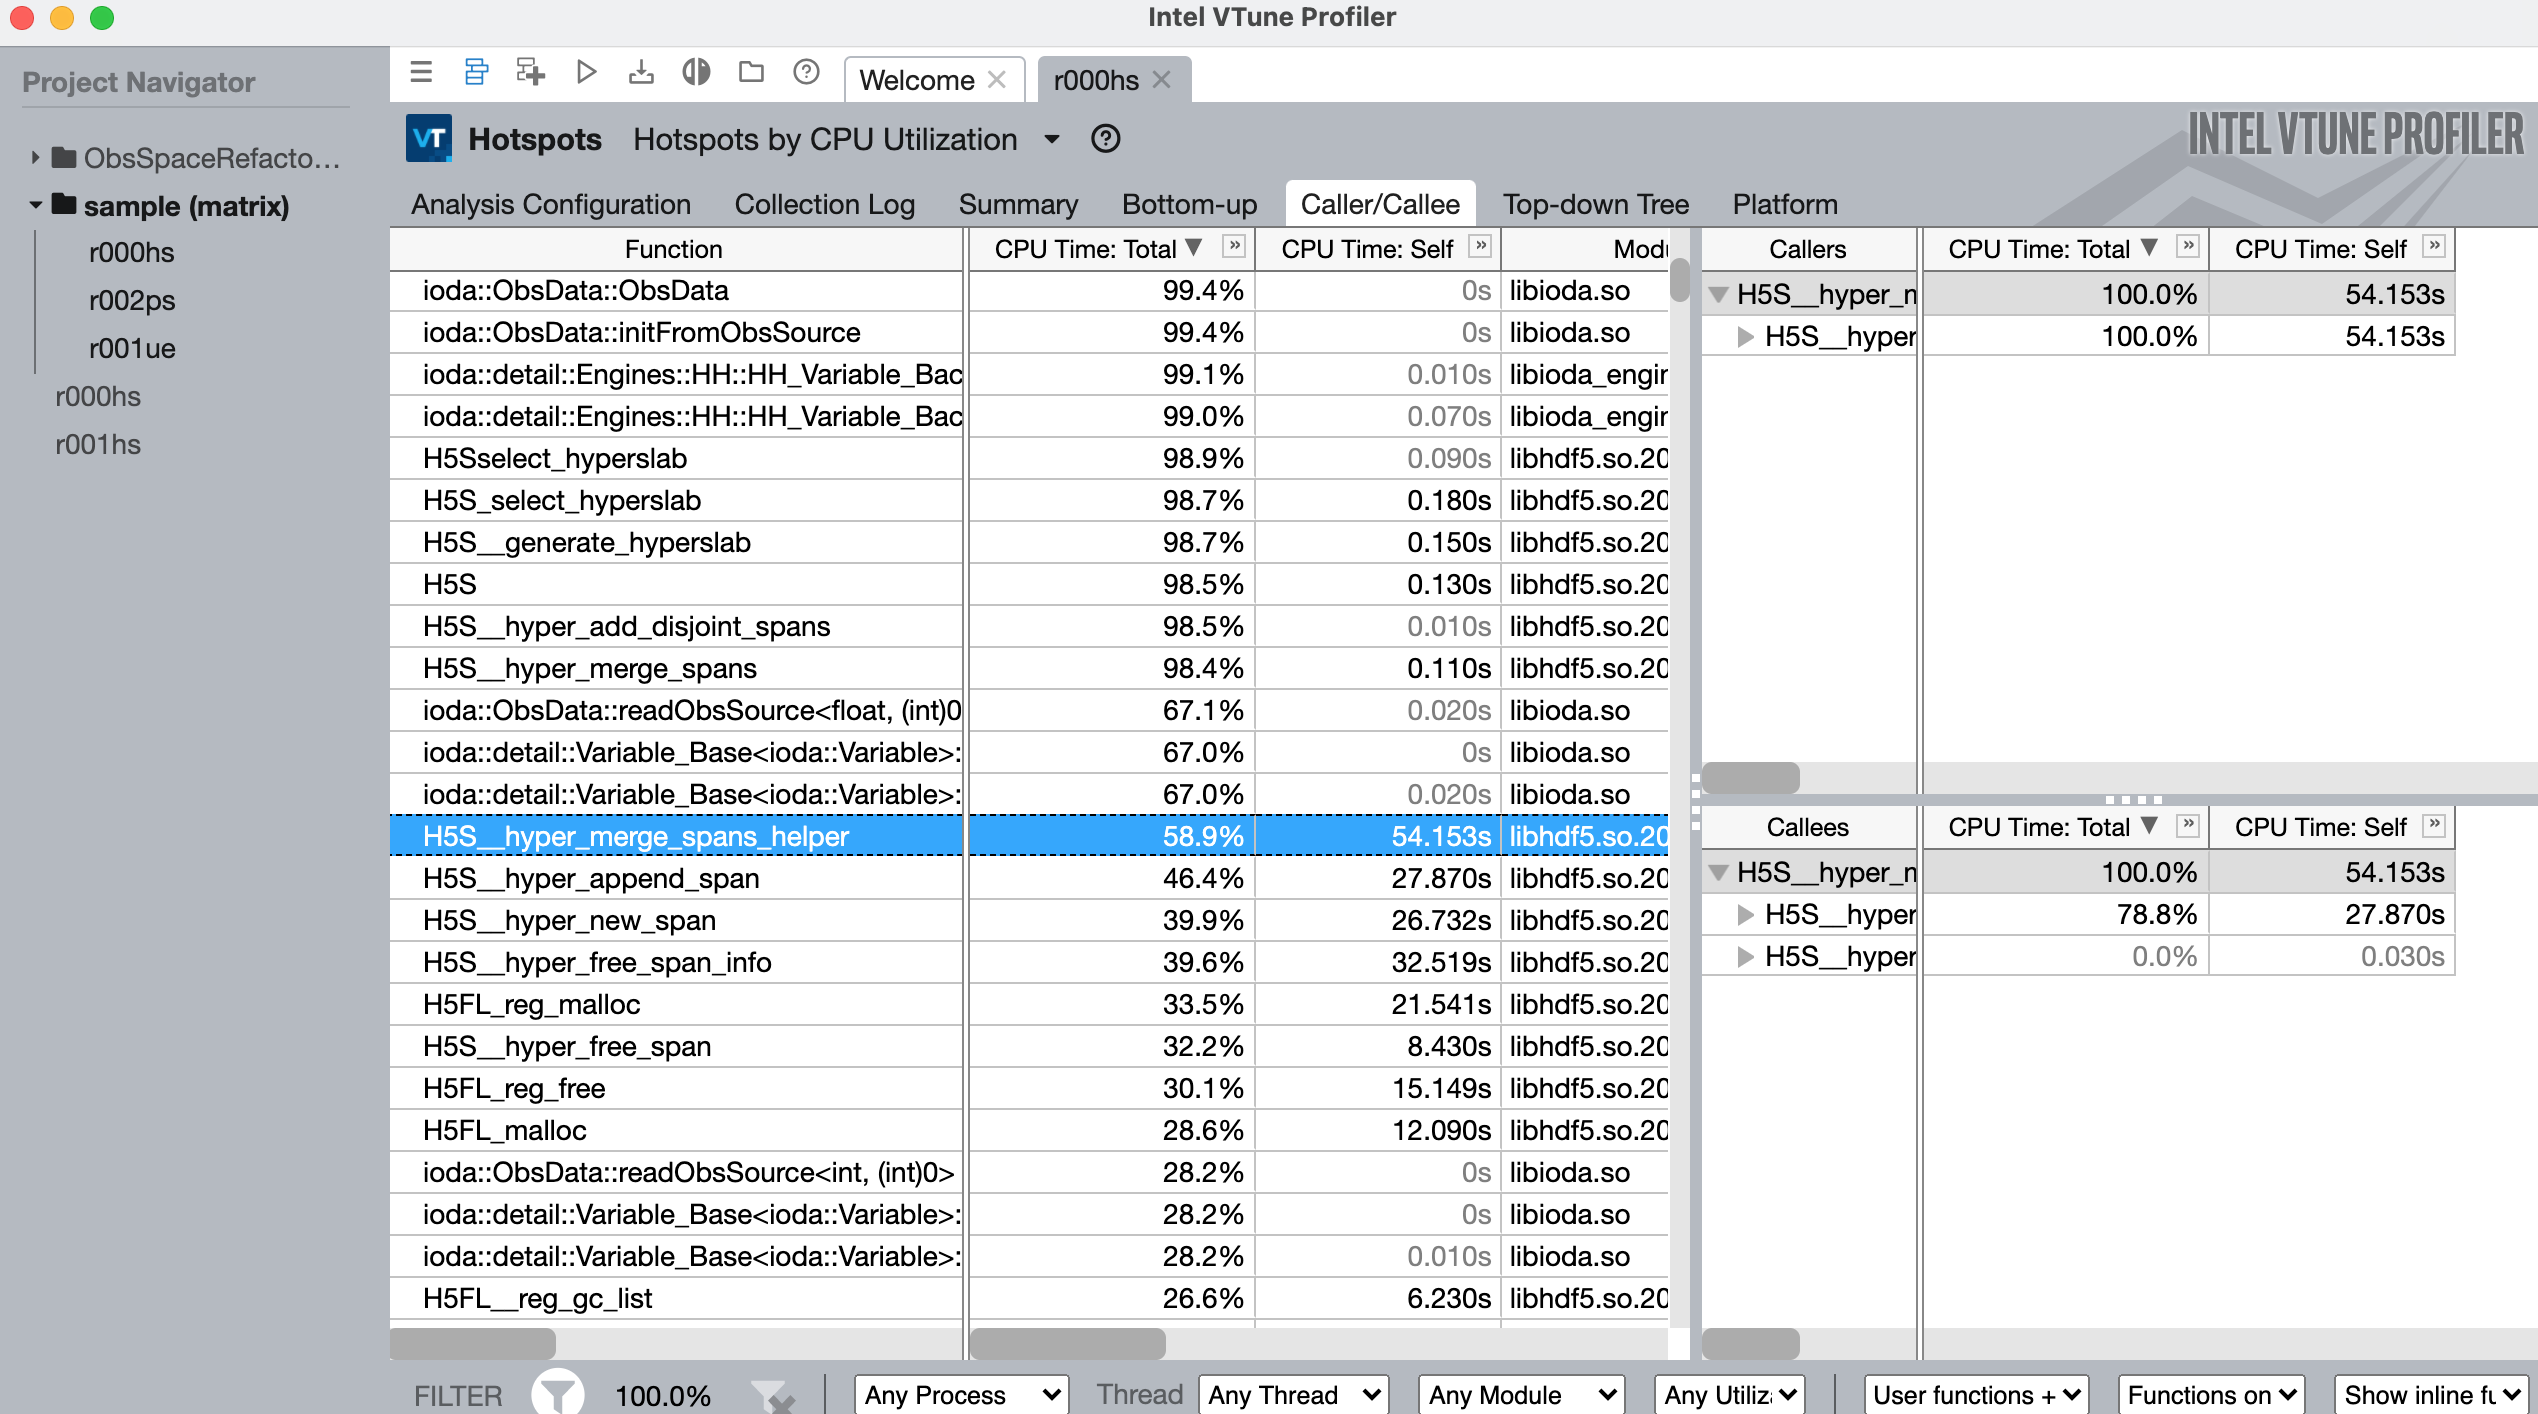

* Vtune image above shows that 59% of the runtime is spent in the `H5S__hyper_spans_merge_helper` function. This is the function that is used to implement the dimension index selection method. This is being applied on the input file, and can be mitigated by doing a regualr hyperslab selection on the input file and doing the index selection in memory.

* Some other issues with performance
    * lat, lon in applyMpiDistribution function (FrameRead)
        * Reading in entire variable instead of frame
    * char arrays converting to vector of strings
        * Replace char arrays in file with vector of strings

* Running vtune on S4
    * `/data/users/sherbener/project/ufo-bundle/build/ufo/test/vtune_*`

* Analyzing vtune results on MacBook
    * `~/projects/vtune/`

# Performance, 2/8/21

* Appears issue is the dim index style of selection is slow for a file since it is built from a series of hyperslab style selections.
    * MPI seems to exacerbate this inefficiency. Perhaps having all MPI tasks open the file and do the dim style selection is the cause.

* Solution is to pull a frame into memory using a single hpyerslab to grab the current frame from the file.
    * After the frame is in, then figure out the frame index and record numbers
    * Then select from the frame (in-memory) using the dim index style which should run much faster

* 

# Performance, 2/17/21

* Issue now is that there are too many variable opens on the file backend (ObsFrameRead)
    * H5Dopen is bottleneck
    * Jason-2-2018-04-15.nc example
        * nlocs = 160607
        * 6 variables
        * 963,642 values to read in

* Solution is to record var objects when running collectVarDimInfo and use those instead of repeated variable opens
    * Change varList and dimVarList to vector of pairs where the pair is a name and Variable object

# Performance, 2/23/21

* Issue now is searching for the dimensions attached to variables
    * ctest -R test_ufo_instrument_iasi_metop-b_gfs_HofX
        * develop, relwithdebinfo, 10.1s (ObsSpace ctor, 8.7s)
        * perf2, relwithdebinfo, 147s, (ObsSpace ctor, 145s)
        * 2 mpi tasks - MPI exacerbates the problem since each task reads the input file
            * one process -> 121s (ObsSpace ctor, 120s)
            * not 2x slower, but does slow down
    * H5Aopen is bottleneck
        * Vtune caller/callee listing: 
            * collectVarDimInfo (80%)
            * var.getDimensionScaleMapping (78%)
            * H5Aopen (73%)
    * iasi_metop-b_obs_2020110112_m.nc4
        * h5dump time is 9s

# Add GPTL to engines part of ioda, 2/23/21

* Under path src/engines/
    * cmake/Dependencies
        * `find_package(jedicmake)`
        * `find_package(GPTL)`

    * ioda/CMakeLists.txt
        * `target_link_libraries(ioda_engines PUBLIC GPTL::GPTL)`


* `ecbuild -DENABLE_GPTL=ON -DENABLE_AUTOPROFILING=ON path_to_source`

* `export OOPS_PROFILE=1` before running ctest

* customize data collection
```
.
.
.
#include <gptl.h>
.
.
.
int ret;
ret = GPTLstart("forecast");
.
.
.
ret = GPTLstop("forecast");
```

# YAML control for engine specification, 3/10/21

* obs data out, 3 options
    * overwrite -> create, truncate if exists
    * create -> create, error if exists
    * update -> open, read/write

* Change ObsIo, ObsFrame, constructors to accpet an engines backend name and parameters objects. Then have one ObsSpaceParameters class create these.

```
obsdatain:
    obsfile:
    obsgrouping:
    max frame size:
    engine: [ H5file, BUFR, ODB ]
        mode:

obsdataout:
    obsfile:
    max frame size:
    engine:
        mode:

generate:
    random:
    list:
    engine:
        mode:
        alloc bytes:
        flush: [ true | false ]
```

* engine
    * names
        * H5file, H5mem, ODB, BUFR
    * open mode:
        * read only, read write
    * create mode:
        * overwrite, no overwrite

# Ioda Python API, 4/2/21

* Mac OS
    * Can't get to work in miniconda
    * Xcode python doesn't work either
    * Was able to get it to work with homebrew python
        * brew install python@3.9
            * pip install numpy
            * pip install scipy
            * pip install awscli

* ecbuild -DBUILD_PYTHON_BINDINGS=ON

* after build
    * `LD_LIBRARY_PATH="build_dir/lib:$LD_LIBRARY_PATH"`
    * ctest -R python
    * Run a test
        * `LIBDIR="build_dir/lib/python3.9"`
        * python3 ../ioda/src/engines/Examples/Python/example.py

# IODA-V2 Performance, 4/9/21

* Orion, EWOK

* Experiments
    * ~/projects/EWOK_R2D2/experiments
    * a03l - tutorial_hofx.yaml, develop
    * a03y - tutorial_hofx.ioda-v2.yaml, ioda-v2
    * a03z - tutorial_hofx.ioda-v2.perf.yaml, ioda-v2-putdb-batch

* Basic process
    * ewok_create_experiment yaml_file
    * ecflow_ui &
        * click with 2 fingers to to right click
        * right click on tasks to get drop-down menu

* Work area
    * /work/noaa/da/herbener/ewok_experiments/exp_name
        * ecwok/2020-12-15T00:00:00Z
            * first cycle H(x) backgrounds, obs, yaml for hofx app
        * bundle/build
            * build area for fv3-bundle
            * bundle dir holds source

* ioda-v2
    * need to build upgrader
        * Ewok builds from the fv3-jedi build directory which doesn't build upgrader
        * cd to bundle/build directory
        * make -j8
        * ctest -R get_
    * cd to ewok/2020-12-15T00:00:00Z
        * mv old obs files out of the way
        * run upgrader on old obs files
    * in ecflow_ui
        * suspend a03y (suspend whole experiment)
        * requeue hofxCycle (reset to cycle 1)
        * execute HofX3D (manually run first cycle)

# IODA-V2 Performance, 4/14/21

* New experiments
    * a04k - develop
    * a04l - ioda-v2
    * a04m - ioda-v2-putdb-batch

* Still have different number of obs selected, rejected
    * Only for aircraft and ship

| obs type | code base | nobs | min | max | RMS |
|----------|-----------|------|-----|-----|-----|
| Aircraft | develop | 823832 | -63.069 | 303.322 | 127.333 |
| Aircraft | ioda-v2 | 823420 | -63.069 | 102377 | 2075.41 |
| Ship | develop | 40018 | 32093.2 | 104608 | 100343 |
| Ship | ioda-v2 | 39411 | -196610 | 104614 | nan |

* initial performance

| quantity | develop | ioda-v2 | notes |
|----------|---------|---------|-------|
| Total | 297s | 348s | ioda-v2 roughly 17% slower |
| fillGeoVals | 117s | 117s | this is top time as reported by OOPS |
| ObsSpace | 17.1s | 35.0s | If the times for ObsSpace ctor, dtor match develop, |
| ~ObsSpace | 1.21s | 15.8s | the total slowdown is roughly 6% |

* The remaining 6% slowdown (ie, besides ObsSpace ctor, dtor) is likely due to the radiance channel selection from the ObsSpace container
    * Using the dim indexing style of selection
        * No caching of selection due to unique selection patterns

# IODA-V2 Performance, 4/28/21

* Tested fix for issue with different obs being rejected/assimilated
    * a05x - develop experiment (tutorial based)
    * a05z - ioda-v2 experiment (tutorial based)
    * Assimilated all obs from the tutorial

| quantity | develop | ioda-v2 | notes |
|----------|---------|---------|-------|
| Total | 299s | 331s | ioda-v2 is roughly 11% slower |
| fillGeoVals | 115s | 116s | top time reported by OOPS |
| ObsSpace | 21.5s | 31.2s | If the times for ObsSpace ctor, dtor match develop, |
| ~ObsSpace | 1.55s | 9.76s | the total slowdown is roughly 5% |

* Tried doing the full blown testbed H(x) experiment
    * jedi_gdas_009.yaml - develop
        * experiment a060
    * jedi_gdas_009.ioda-v2.yaml - feature/ioda-v2 branches (fv3, ufo, ioda)
        * experiment a061
    * Builds succeeded, but the HofX3D jobs crashed
        * Both develop and ioda-v2 experienced crashes
    * Orion was being scheduled for maintenance on the 27th (I tried this at the end of the day on the 26th) which might have caused some of the problems (if everyone was loading up their last-minute jobs for example)

* Orion was up this morning, but it is having issues from the maintenance

* Will try again after Orion is back on line

# IODA-V2 performance, 5/3/21

* ioda-v2 branches have all the performance upgrades added in

* Tried tutorial testbed H(x)
    * a05x - develop
    * a05z - feature/ioda-v2

* Trial 1

| quantity | develop | ioda-v2 | notes |
|----------|---------|---------|-------|
| Total | 286s | 316s | ioda-v2 is roughly 10% slower |
| fillGeoVals | 114s | 117s | top time reported by OOPS |
| ObsSpace | 19.6s | 29.5s | If the times for ObsSpace ctor, dtor match develop, |
| ~ObsSpace | 0.842s | 5.18s | the total slowdown is roughly 6% |

* Trial 2

| quantity | develop | ioda-v2 | notes |
|----------|---------|---------|-------|
| Total | 291s | 321s | ioda-v2 is roughly 10% slower |
| fillGeoVals | 115s | 119s | top time reported by OOPS |
| ObsSpace | 18.1s | 29.9s | If the times for ObsSpace ctor, dtor match develop, |
| ~ObsSpace | 1.03s | 5.01s | the total slowdown is roughly 5% |


# IODA discussion with Ryan 7/23/21

* Trying to design a set of "atomic" functions that can be used to build larger applications
    * copy
    * merge
    * transfer engine
        * part of Group
        * intercept calls
        * mutate names
        * remap dimensions
        * transform between gridded and list of locations
        * YAML driven
        * Separate concerns from parts that copy data

* Notes for reader flow
    * Might work well to make a first pass through the file that determines how to orgnaize records and where they get distributed (MPI)
        * Only have to read a handful of variables
            * datetime
            * lat
            * lon
        * Read in the entire variable in one call
            * This works well for hdf/netcdf due to chunking and internal tree structure
            * Probably not as well for odb, bufr
    * Once the records and distribution are determined, use that information to move data to the assigned MPI PE
        * Could write data into separate files - one per PE
            * This would allow the PE's to simply read the file directly into the ObsSpace (no processing)
        * OR, read with rank 0 and distribute (this may not be the best solution)
        * OR, read with set of PEs and distribute

# Ryan, Fortran API 8/13/21

* jckit branch for passing strings (string module)
    * feature/initial-proposal

* strings
    * single string OR
    * Array of strings of variable length
        * Eg, a list of the child group names under a given group

* Fortran has support for class "named type"

* Do groups first, create separate modules
    * Engines -> backends
    * Group

* Difficulty with Intel compiler
    * Double frees

* Fortran preprocessor -> template macro
    * This method yields "classes" that have nice programming features
    * Ie, you can make the Fortran code look like the C++ code
        * C++: ioda.g1.list()
        * Fortran: ioda%g1%list()

* This is why the C interface is done like this (preprocess -> temlate macro)
    * Using a hierarchical arrangement of structs to make it look like C++
        * C++: ioda.g1.list()
        * C: ioda.g1.list()

* ioda guts are in C++ and the primary API is also C++
    * Primary purpose of the C API is to get to the Fortran API
        * It could, in theory, be used for other languages such as Java
    * The Python API binds directly to the C++ (pybind11)

* jckit features (initially)
    * Strings
    * os/file system queries
    * error system
        * C++ exceptions
        * TRY/CATCH macros for C

# IODA Converter sprint prep, 10/1/21

* Examples
    * tropomi
    * marine profile
    * hgodas_insitu

* Code
    * ioda repo -> feature/fillval (PR)
    * iodaconv repo -> feature/v2profile

* Sprint
    * Oct 25-27 (Mon-Wed), 1-2 ET and 3-5 ET each day
    * Presentation slides (Cory started an outline)
    * Instructions based on how examples were ported

# pybind11, 10/11/21

* Build and test pybind11
    * `cmake -DPYBIND11_TEST=ON path-to-source`

* target_link_libraries command for the ioda python API
    * Embed mode
        * Use when calling python functions from C++ code
        * `target_link_libraries(_ioda_python PUBLIC Python3::Python)`
    * Module mode
        * Use when creating a python module out of C++ code
        * This is what we are doing in ioda
        * `target_link_libraries(_ioda_python PUBLIC Python3::Module)`

# Miniconda3 and pybind11, 10/11/21

* install miniconda3 from: https://docs.conda.io/en/latest/miniconda.html

* use conda to install:
    * netCDF4
    * python-dateutil
    * scipy
    * pyyaml
    * cartopy
    * pandas
    * pytest (for pybind11 tests)
    
* Put `~/opt/miniconda3/bin` at front of PATH

* `Python3_ROOT=~/opt/miniconda3 ecbuild path-to-source`

* An alternative to building pybind11 in jedi-stack is to install pybind11 into your python installation

# Skylab converters, 12/17/21

* Ben Ruston
* eccodes based -> containers, HPC modules
    * ECMWF library -> jedi-stack
    * ECMWF Python API -> PyPI
    * nice utilities provided in `bin` direcotry of library installation

* h5py
    * Collides with jedi-stack hdf5 library version
        * h5py - hdf5 1.12.1
        * jedi-stack - hdf5 1.12.0
    * Can pip install building from jedi-stack hdf5 library
        * install h5py with parallel io enabled
        * `CC="mpicc" HDF5_MPI="ON" HDF5_DIR=/opt/modules/clang-12.0.5/mpich-3.3.2/hdf5/1.12.0 pip install --no-binary=h5py h5py`

* ioda-converters
    * GNSSRO
        * feature/generic-gnss-ro-decoder-to-ioda
        * PR #719
        * Issue #711
    * ATMS
        * feature/generic-atms-ingest-converter
        * PR #727
        * Issue #721
        * Can take both netcdf and hdf5 as input
            * hdf5 -> two files (data, geolocations)
            * netcdf -> one file
        * Comments show variable names for both hdf5 and netcdf input files
    * RAOB (radiosonde)
        * feature/generic-bufr-LDM-raob-decode
        * Issue #722
        * Concatenate a bunch of input files
    * Utilities
        * assign_values()
            * converts double precision (int and float) to single precision
            * replaces large double precision missing values (outside single precision range) with single precision missing values
        * concatenator

    * Next obs type: AMV

* Skylab experiment
    * Aug 1, 2021
    * Full month
    * 127 levels
    * Full resolution files
    * One thinned file

* We need converted obs for two dates
    * Dec 15, 2020 - for testing purposes
    * Aug 1, 2021 - for Skylab experiments
    * Greg has collected RAOB for these two dates
        * Put these data on my MacBook: ~/project/data/Skylab

# IODA#567, datetime corruption, 1/18/22

* ioda-upgrade.x gets corrupted datetime values
    * iasi_metop-a_obs_2018041500.nc4 (ioda v1 example)
    * iasi_metop-a_obs_2018041500.h5  (ioda v2 example)

* MacBook
    * ~/projects/DEVELOP/ioda-bundle/build_debug/bin/ioda-upgrade.x
    * ~/projects/data/NCAR/IASI
    * Read of MetaData/datetime ouf of input file does not work
        * line 358 in upgrade.cpp
    * Copy of file using ncks doesn't help
        * ncks iasi_metop-a_obs_2018041500.nc4 test.nc4
        * followed by ioda-upgrade test.nc4 test.out.nc4
        * fault persists
    * Strip out all variables except datetime and 2 brightness temperature channels
        * test.only-dt.ioda.v1.nc4
        * upgrade works
    * Reduce all variables to 10 locations
        * test.ioda.v1.nc4
        * upgrade works
    * Doesn't appear to be confusion with the character set (ASCII vs UTF-8)
        * The input is ASCII and ASCII is a proper subset of UTF-8

* input file
    * MetaData/datetime
        * (nlocs, ndatetime)
        * nlocs: 321,707
        * ndatetime: 20
        * organized as 6,434,140 strings of length 1 in file

* Read variable code
    * 6,434,140 total elements in string vector
        * Since data is organized as this many length 1 (fixed length) strings
        * But we want 321,707 strings
    * Marshaller creates a vector 51,473,120 bytes long to hold 6,434,140 char pointers
    * HH-variables.cpp
        * Line 696 -> call to H5Dread
            * memSpace() is set to 0 (H5S_ALL)
            * fileSpace() is set to 0 (H5S_ALL)
        * For file that works, you get each entry set to the datetime string characters in in_bufr (vector of char)
        * For the file that doesn't work, you get garbage in in_buf
        * For both files that work and don't work, you get strLen == 1 and numStrs == 6,434,140

* Debugger
    * breakpoints
        * upgrade.cpp, line 744
        * HH-variables.cpp, line 692

* Acts like it loses track of the variable, or dataspace and reading from the wrong location in the file

* HH-variables.cpp, line 706 is malloc'ing 2 byte elements 54M times!

* Can we close this issue?
    * NCAR seems okay with workarounds they developed
    * Only an issue with large number of variables open at the same time where those variables hold a large amount of data. This situation should go away once we get everyting transitioned to ioda v2 (since it is coming from have a separate variable for each channel).

# IODA#576, File I/O performance improvements, 1/21/22

* Short term performance issues are top priority
    * Reader/Writer
    * Get it to a level that is usable by experimenters

* Yannick: File read -> 2 basic techniques
    * All from one file OR
    * Split files
    * Leaning toward split files

* Dom: Sionlib is very efficient

* Start with the writer
    * Meet again on 26th, 27th to review design
    * AMS week (Mon 24th - Thu 27th)
        * JCSDA symposium is Tue 25th

* Need a good test case for the debugger

* Develop off of the ioda typing improvement feature branches
    * feature/???

* Do these changes at the ioda-engines level

* Do profiling with vtune
    * Disk I/O time is reported so we can know when we can't do any better

* Reader
    * Consistent chunk sixe in files
    * Quickly read into memory
    * Round robin on chunks
    * Distribute after in memory
        * Don't need to distribute any more if using RoundRobin Distribution
    * Prime the above by reading entire variables for filtering and grouping
        * datetime, lat, lon, grouping vars
        * figure out entire distribution

* Writer
    * Essentially the reverse of the reader
    * Figure out ordering of locations first so you can "records" together
    * Pull these into communicator group and contruct consitstent chunk sizes
    * Write round robin style from communicator group

* Communicator groups
    * Smaller sizes for conventional obs types
    * Larger sizes for radiance
    * Need to figure out scatter/gather as you go
    * Each sub-group handles file I/O for one obs type
        * I.e., one subgroup per obs space/obdatain/obsdataout spec in the YAML

* Ideas
    * Files are all created with similar chunk sizes
        * Try to only vary the locations dimension to resize chunks
        * Conventional will have more locations, radiance (2D) less
        * Include all channels with each location (don't split up channels)
    * MPI
        * MPI_Comm_split(total_comm, color, key, comm_out)
            * comm_out contains all processes with matching color value
            * key is used to determine the rank in the new group (comm_out)
            * Each process has access to the total communicator group plus its split communicator group
                * E.g., two rank numbers, one for each group
    * HDF5
        * Is the HDF VOL programming layer useful for this?
    * Reorganize input files into frames that hold what each MPI task needs?
        * HDF5 -> extra hierachical layer in the group structure
        * ODB -> frames in ODB file
    * New app based on ioda-engines to experiment with chunking strategies
        * load up vars programmatically
        * write out file
        * control var sizes, chunking schemes from YAML
        * Run with various numbers of MPI tasks

* Someone from NOAA, NCAR, Met Office to help with project

# IODA#576, File I/O Performance, 1/26/22

* General architecture picture (added to issue 576)

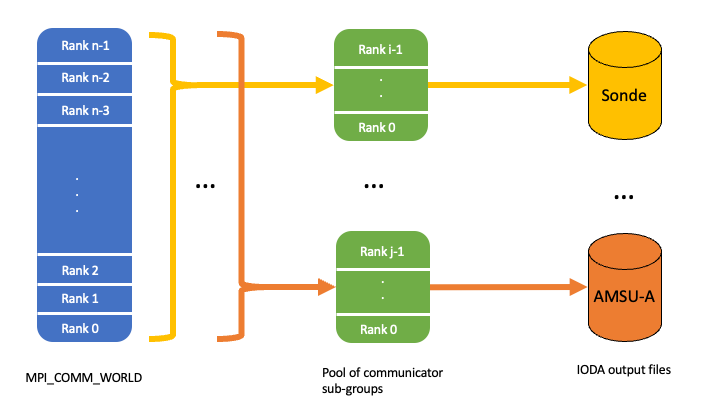

* For the communicator group in the middle column
    * One extreme is a single process sub-group for each obs type
    * Other extreme is all processes for each obs type

* How to control this?
    * Single process run -> write files in series
    * Handful of processes -> pool the communicator groups
        * Line them up and when one finishes, put it on the next pending file
    * Lots of processes -> Run all groups at same time.
        * Don't necessarily need all processes spread across the comm pool

* Enable two types of parallelism
    * Write each file in parallel IO mode
    * Write all files in parallel

* Inspect the YAML to get the list of obs spaces

* Inspect the obs spaces to get an estimate of the ideal number of procs in each comm group
    * Also to get the best chunk sizes

* Want to have optimal chunk size for each variable
    * Look at dimensions to do this
    * Only adjust nlocs dimenaion

* Figure out the pools
    * Probabaly better to have two files in parallel with fewer processes per file versus two files in series with more processes per file

* What happens when there is a mismatch between the number of processes that come back into the pool and the next IO task?

* What to do about processes arriving lateto the pool because of the task they were doing before the saving of the obs space?
    * All obs space saves won't initiate at the same time

* The pool is like heap memory management, but much simpler
    * No fragmentation
    * No garbage collection
    * Put all processes into a "free" group at the start
    * When a write is initiated, allocate processes from the free pool
    * When write finishes, place the processes back into the free pool
    

* Controls
    * Maximum number or processes in a single pool
    * Maximum number of files that can be open
    * Who gets priority for writes?
        * Do we want larger files to have higher priority?
        * Is this even enforcable?
    * Do we want to limit how many processes can participate in the pool?
    * Do we want IO function to create an MPI barrieer until it finishes?
        * Would be nice to avoid this
        * All processes are blocked at beginning and when last file is picked up, all processes that free up are released


# IODA#576, File I/O Performaance, 1/27/22

* Chunking exploration tool
    * feature/test-write-chunk
    * control
        * mpiexec
            * nprocs
        * yaml
            * chunk size
            * total number of locations
            * total number of channels
            * pattern to write chunks into the file
                * block -> all of rank 0's chunks, then all of rank 1's chunks, etc.
                * interleave -> round robin order among all ranks
    * Steps
        * Figure out chunk starts and chunk counts for each rank on rank 0
            * Scatter the result to the other ranks
        * Create 10 vars, 6 1D, 4 2D (nlocs X nchans)
        * Allocate a singel 1D vector and single 2D vector matching the chunk size
        * Open file in parallel mode
        * Write chunks in the specified pattern
            * Hyperslab selection
     * Scatter
         * MPI call:
             * scatter is for fixed counts on every rank
             * scatterv is for variable counts on every rank
             * `scatterv(sendbufr, sendcounts, displs, sendtype, recievebufr, recvcount, recvtype, root, comm)`
                 * sendbufr: address of buffer
                 * sendcounts: counts, integer array, lenght == comm group size
                 * displs: starting offsets, integer array, length == comm group size
                 * sendtype: data type
                 * receivebufr: address of receive buffer
                 * recvcount: number of elements in receive buffer
                 * revtype: data type
                 * root: rank number for root of scatter
                 * comm: communicator group
             * In both scatter and scatterv, the first count of elements goes to rank 0, the next count of elements goes to rank 1, etc.
         * eckit call
             * function of the comm group object
             * templated functions
             * use std::vector argmuments for the data buffers

# IODA File I/O Performance meeting, 1/28/22

* Yannick
    * Calls to saveToFile
        * oops loops through obs spaces and calls saveToFile
            * not all that asynchronous
        * Split communicator in n_obs_types pools
            * non-blocking calls for efficiency
        * Case where n_obs_spaces > ntasks
            * Run sequentially
        * Do the above case first to get the collect and write to file code written
        * Then add the parallel case
            * Non-blocking for obs gathering

* After loop that calls saveToFile, there is not much going on, just destructing all the objects

* Francois H
    * One proc per node
    * Allow for using OpenMP and shared memory (which can be effective)

* Cory
    * Pay attention to compression versus speed of access tradeoff

* Use the ZenHub issue (IODA#576) for communication from now on
    * We'll meet if and when necessary

* Work off of develop branch

* Steps
    1. One pool
        * write one file per process in the pool
            * still get multiple files, but much less, manageable number
        * sequentially go through teh obs spaces
    2. Write to one file
    3. Add more pools
        * wrte fiels in parallel
        * Use non-blocking calls to get the different obs spaces to write at the same time
        * What to do with case where you don't have enough pools to handle all the files
            * Mainly for unit or small testing
            * Go back to step 2) and use just one pool?

# Ioda File I/O Performance, 1/28/22

* feature/write-pool

* Don't use framing

* Call to saveToFile
    * instantiate an ObsIoPool object
        * number of procs
        * anything else?

* Functions
    * Determine chunk size
    * Data transfer - MPI communication
    * How to organize chunks
        * Which locations from which ranks
        * Keep records together
            * Perhaps write out the record numbers/grouping
        * Don't let the locations from a given rank get split up across chunks
            * This will naturally keep records together
    * Write the file
        * Fix the issue with repeated obs from Halo and Inefficient distribution
        * Check consistency of obs spaces
            * same global attributes
            * same variables
                * same data repeated when variable is not dimensioned by nlocs
            * same dimensions, dim scales
                * same data for dims other than nlocs
        * Steps
            * Create file
            * write global attributes
                * get these from rank 0 (should be same in all ranks)
            * Write dimensions, dim scales
                * get nlocs pieces/sizes from all ranks
                * other dimensions from rank 0 (should be same in all ranks)
            * Variables
                * Not dimensioned by nlocs, get from rank 0 (should be the same on all ranks)

* How to get 1D and 2D pieces to line up
    * each proc in obs pool wants to write into a file using different number of locations in a similar chunk size
    * Need to know all of the dimension combinations, and dim sizes, var types
        * nlocs X nchans
        * nlocs
        * nchans
    * Have rank 0 do an inspection of the obs spaces to figure this out

* YAML configuration
    * chunk size in bytes
    * chunk cache size in bytes
    * maximum file size
        * problemmatic if size gets in TB range

* From the YAML specs, need to figure out how many locations go into each dim combo
    * locs per chunk = (chunksize in bytes) / (other dim sizes * data type size)
    * 2D: nlocs X nchans
        * results in m locations X n channels, where n is fixed
    * 1D; nlocs or nchans
        * make the chunk size m * n from the 2D calculation
            * unless m * n is larger than nlocs or nchans

# Ioda File I/O Performance, 2/2/22

* Step 1 tasks
    * Design
        * one pool 
        * one file per task in the pool
        * go through the obs spaces sequentially
    * Steps within this task
        * Replace IodaUtils colllectVarDimInfo with VarUtils version
        * Remove framing from the writer
        * Add the pool feature

* collecVarDimInfo differences
    * These two versions use different data structures
    * VarNameObjectList in IodaUtils -> Vec_Named_Variable in VarUtils
        * IodaUtils
            * `vector<pair<string, Variable>>`
        * VarUtils
            * `vector<Named_Variable>`
            * Named_Variable is a struct with "name" and "var" data members
    * VarDimMap in IodaUtils -> VarDimMap in VarUtils
        * IodaUtils
            * `map<string, vector<string>>`
        * VarUtils
            * `map<Named_Variable, Vec_Named_Variable>`

* Writer
    * Write variable by variable instead of frame by frame
    * Rank zero
        * Create dimensions
        * Create variables
        * Write global attributes
        * Write varibable attributes
    * All ranks
        * open/create file
        * Gather variable data pieces
        * write data into variables
    * Utilities for ioda engines
        * copyAttributes
        * copyVariables
        * copyGroups
    * Pool feature
        * Up to a limit in total number of processes, each process simply writes its own obs space (like before)
        * Above the limit, a pool is formed and used to write one file per process in the pool
        * Always have a pool
            * Below limit - no mpi communication, just write
            * Above limit - mpi comm, gather variable data, write files
                * Pools pull in data from others and append to their obs space
                * Is this okay? - seems so since we are about to destruct the obs spaces
        * Step 2 - have procs in pool open one file in parallel mode and write
        * Step 3 - allow for more than one pool